# Customer Segmentation

## Background

This dataset contains all purchases made for an online retail company based in the UK during an eight month period. We could use cluster analysis combined with RFM analysis to do a customer segmentation.

## Prepare and Explore the Data

For this experiment, we will use [this](https://www.kaggle.com/vijayuv/onlineretail) data from Kaggle platform.

In [ ]:
# Package imports
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', None)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Load data
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Since we want to segment our customers, we have to make sure that `CustomerID` is not null.

In [ ]:
# Check missing value
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We could see that there is missing value in `CustomerID` columns. We could remove those missing values.

In [ ]:
# Remove missing value
df = df[df["CustomerID"].notna()]

df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Then we could do some descriptive statistic.

In [ ]:
# Simple descriptive statistic
df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


Wait, hold on. How come the quantity is a negative number and the unit price is zero? Let's check it.

In [ ]:
# Check anomaly data (Ada berapa data yg kurang dari 0 untuk quantity dan sama dengan 0 untuk price)
quantity_zero = len(df[df["Quantity"] <= 0])
perc_quantity_zero = (len(df[df["Quantity"] <= 0]) / len(df)) * 100
unitprice_zero = len(df[df["UnitPrice"] == 0])
perc_unitprice_zero = (len(df[df["UnitPrice"] == 0]) / len(df)) * 100

print("The data consist of", str(quantity_zero), "rows of data with item quantity less/equal than zero.")
print("About {:.2f}% of total data".format(perc_quantity_zero))
print("")
print("The data consist of", str(unitprice_zero), "rows of data with unit price equal to zero.")
print("About {:.2f}% of total data".format(perc_unitprice_zero))

The data consist of 8905 rows of data with item quantity less/equal than zero.
About 2.19% of total data

The data consist of 40 rows of data with unit price equal to zero.
About 0.01% of total data


Then just remove those anomaly data

In [ ]:
# Remove anomaly
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,397884.000000,397884.000000
mean,12.988238,3.116488
std,179.331775,22.097877
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


Now we're good to go. Lets do some data exploration!

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


The data contains 406829 rows and 8 columns, each row represents each item in a purchasement. The columns are:
* `InvoiceNo` - Invoice number, to identify each invoice
* `StockCode` - Stock code, to identify each item in the inventory
* `Description` - Item's description
* `Quantity` - Number of purchased item in each invoice
* `InvoiceDate` - Date of purchasement
* `UnitPrice` - Item's price per unit
* `CustomerID` - Customer's identification number
* `Country` - Customer's country of origin

In [ ]:
# Check unique value
df[['InvoiceNo', 'StockCode', 'CustomerID', 'Country']].nunique()

InvoiceNo     18532
StockCode      3665
CustomerID     4338
Country          37
dtype: int64

There are 18532 purchasements, 3665 unique item purchased, from 4338 customers that came from 37 countries.

As we seen above, there are 37 countries of customer's origin. Since the retail company is based in the UK, we could simplified the country as UK or Non UK

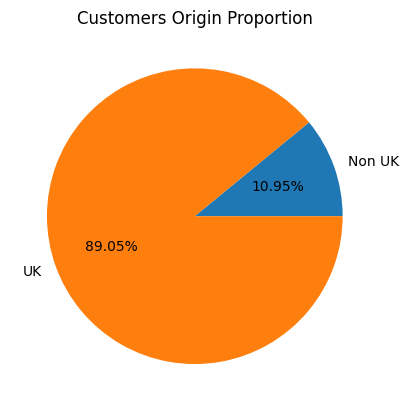

In [ ]:
# Simplify country origin
df['Country_isUK'] = np.where(df['Country']=='United Kingdom', 'UK', 'Non UK')

customers_origin = df.groupby(['Country_isUK']).size()

plt.title('Customers Origin Proportion')
plt.pie(customers_origin, labels=customers_origin.index, autopct=lambda p: f'{p:.2f}%')
plt.show();

Based on the piechart, we could see that mostly our customers are from the UK.

Next, we could analyze the trend of purchasement. First, lets create `TotalAmount` column (`Quantity` * `UnitPrice`). Then, we could transform the `InvoiceDate` data type from string to date.

In [ ]:
# Create new features and cast date column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,UK,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,UK,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,UK,20.34


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     397884 non-null  object        
 1   StockCode     397884 non-null  object        
 2   Description   397884 non-null  object        
 3   Quantity      397884 non-null  int64         
 4   InvoiceDate   397884 non-null  datetime64[ns]
 5   UnitPrice     397884 non-null  float64       
 6   CustomerID    397884 non-null  float64       
 7   Country       397884 non-null  object        
 8   Country_isUK  397884 non-null  object        
 9   TotalAmount   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 33.4+ MB


Then plot the trendline.

In [ ]:
import matplotlib.dates as mdates

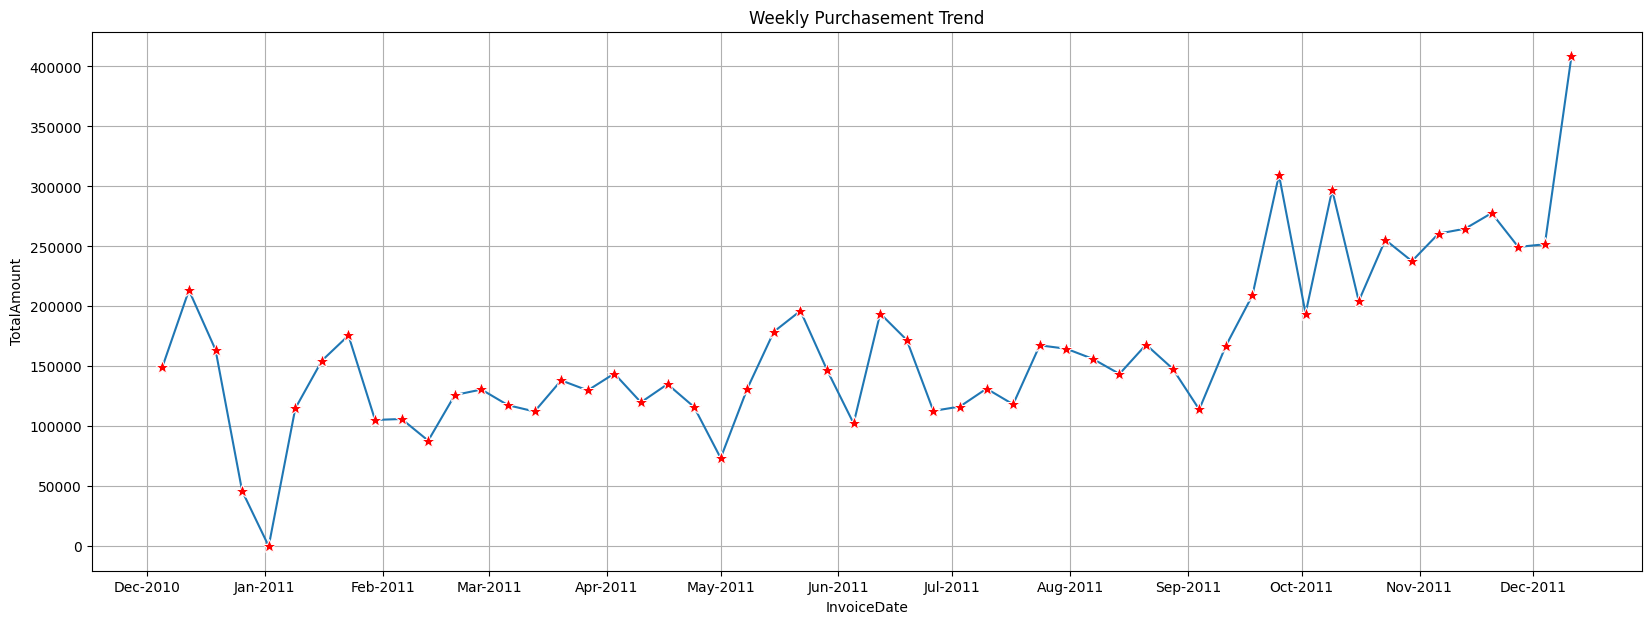

In [ ]:
# Plot weekly trend
weekly_purchasements = df.copy()
weekly_purchasements = weekly_purchasements.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements.index,
    y=weekly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

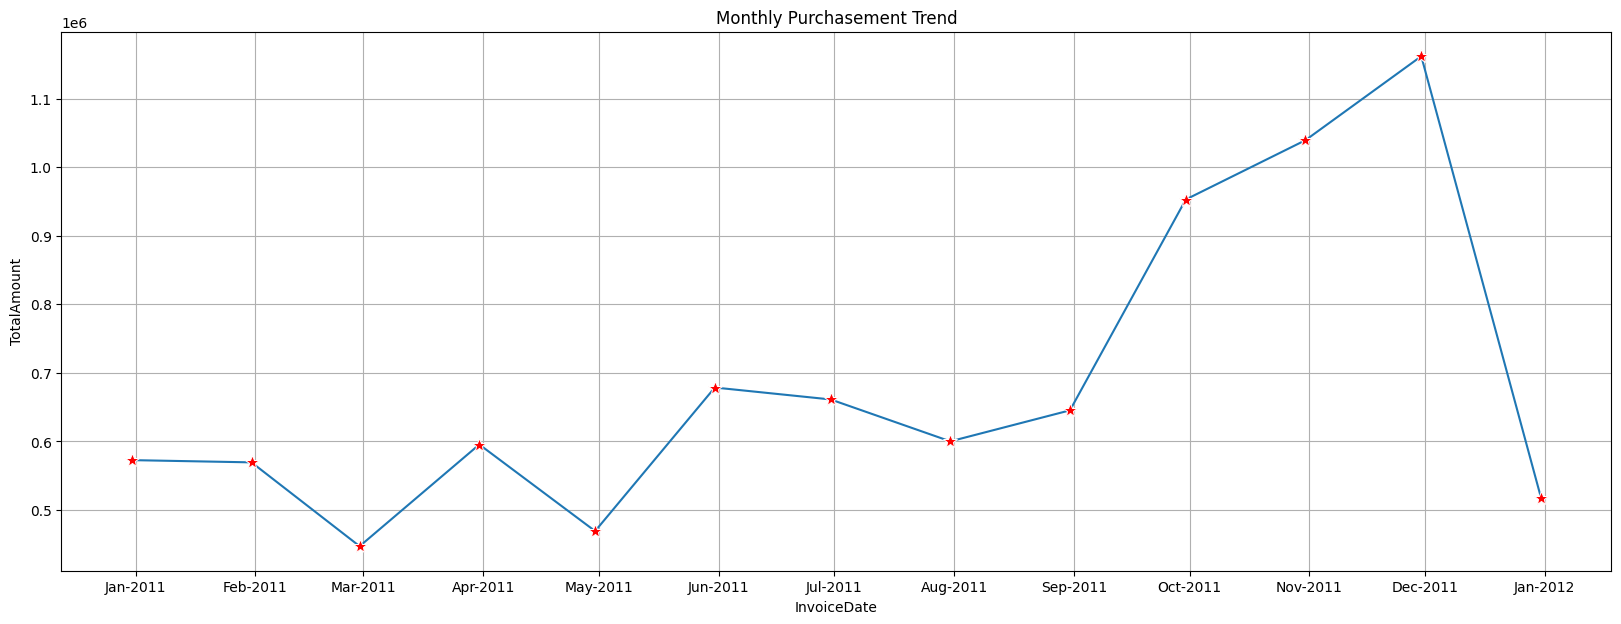

In [ ]:
# Plot monthly trend
monthly_purchasements = df.copy()
monthly_purchasements = monthly_purchasements.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements.index,
    y=monthly_purchasements,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Based on the picture above, it can be seen that there was an increase in total purchases at the end of the year.

## RFM

In this project, we would segment the customers using customer's demography and purchasement behavior. To explain the customer's demography, we could use `Country` column while to explain the customer's purchasement behavior we have to transform our data first to get those information. We could use RFM analysis to get those information.

### Recency

To measure customer's recency, we could substract the latest transaction date in the data with each customer's latest transaction.

In [ ]:
# Get customer's recency
recency = df.groupby(['CustomerID'])['InvoiceDate'].max()
recency = max(recency) - recency
recency = recency.dt.days
recency = recency.rename('Recency')

recency.head()

CustomerID
12346.0    325
12347.0      1
12348.0     74
12349.0     18
12350.0    309
Name: Recency, dtype: int64

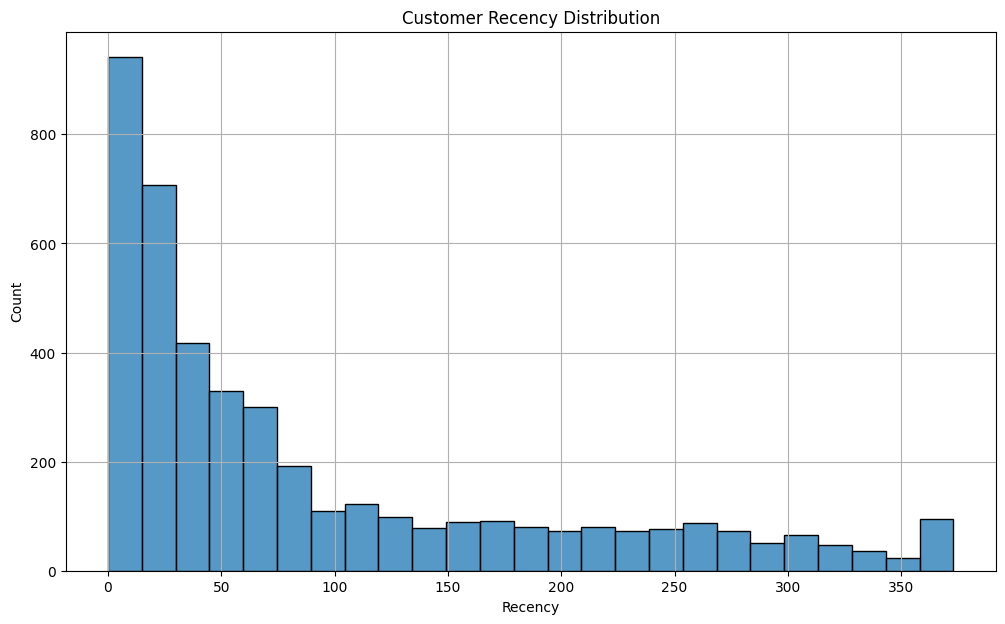

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

### Frequency

To measure customer's frequency, we could count customer's invoice.

In [ ]:
# Count frequency
frequency = df.groupby(['CustomerID'])['InvoiceNo'].count()
frequency = frequency.rename('Frequency')
frequency.head()


CustomerID
12346.0      1
12347.0    182
12348.0     31
12349.0     73
12350.0     17
Name: Frequency, dtype: int64

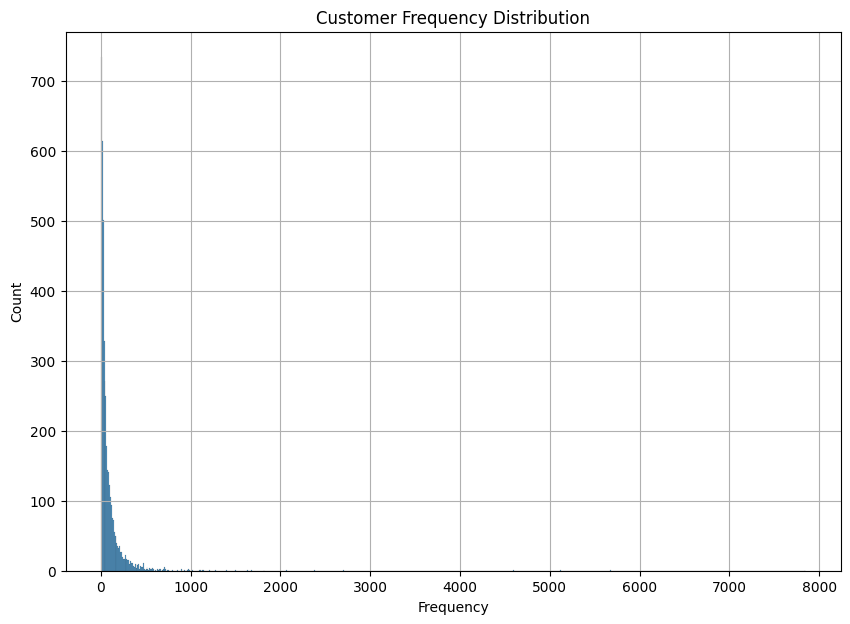

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency)
plt.grid()
plt.show();

### Monetary

To measure customer's monetary, we could sum the customer's total purchasements.

In [ ]:
# Sum the money spent
monetary = df.groupby(['CustomerID'])['TotalAmount'].sum()
monetary = monetary.rename('Monetary Spent')
monetary.head()


CustomerID
12346.0    77183.60
12347.0     4310.00
12348.0     1797.24
12349.0     1757.55
12350.0      334.40
Name: Monetary Spent, dtype: float64

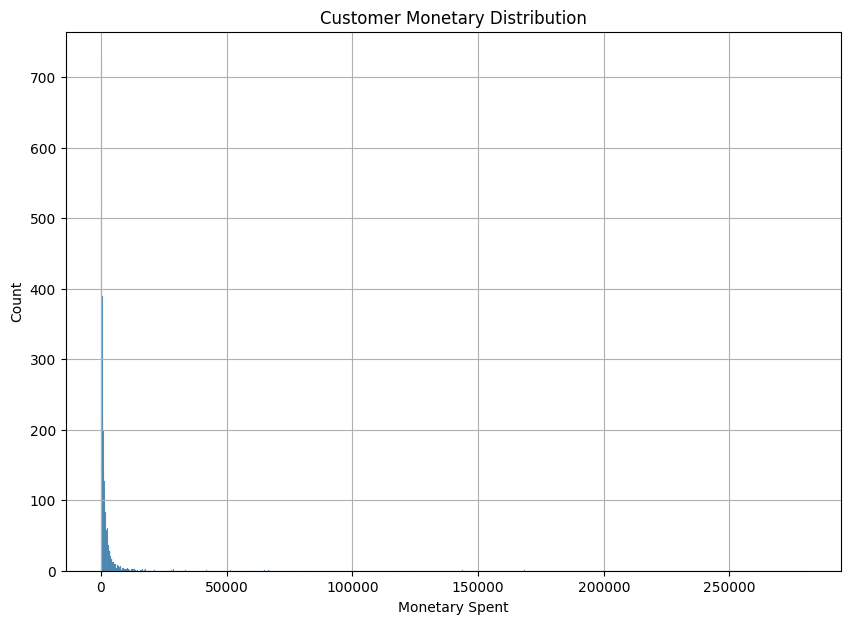

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary)
plt.grid()
plt.show()

### Merge the Data

The data could be separated into two dataframes. The first dataframe (log transformed data) supposed to be used when modeling and the second one (without log transformation) could be used when visualize the result.

In [ ]:
# Get customer's country of origin
country = (
    df.groupby(['CustomerID', 'Country_isUK'])
    .size()
    .reset_index()
    .drop(0, axis=1)
)#chaining method

# Merge the data
df_new = (
  country
  .merge(recency, on='CustomerID')
  .merge(frequency, on='CustomerID')
  .merge(monetary, on='CustomerID')
)

# Set CustomerID as index
df_new = df_new.set_index('CustomerID')
df_new.head()

,Country_isUK,Recency,Frequency,Monetary Spent
CustomerID,,,,
12346.0,UK,325,1,77183.60
12347.0,Non UK,1,182,4310.00
12348.0,Non UK,74,31,1797.24
12349.0,Non UK,18,73,1757.55
12350.0,Non UK,309,17,334.40


### One Hot Encoding

Since our model could just accept the numeric value, we have to recode the non numeric column.

In [ ]:
# Recode the non numeric variable

df_new = pd.get_dummies(
    df_new,
    columns=['Country_isUK'],
    drop_first=True
)

df_new = df_new.rename(
    columns={'Country_isUK_UK': 'Country_UK'}
)

df_new.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,325,1,77183.60,1
12347.0,1,182,4310.00,0
12348.0,74,31,1797.24,0
12349.0,18,73,1757.55,0
12350.0,309,17,334.40,0


### Scaling

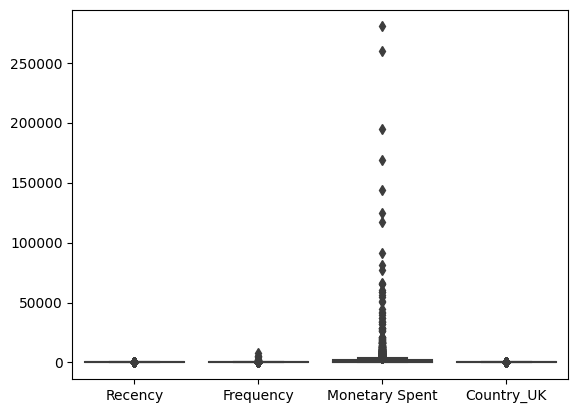

In [ ]:
sns.boxplot(data=df_new)
plt.show()

As we could see, there are variation of range in each column. We have to standardize it first.

In [ ]:
# Scale the data

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_new)

df_scaled = pd.DataFrame(
    df_scaled,
    columns=df_new.columns,
    index=df_new.index
)

df_scaled.head()

,Recency,Frequency,Monetary Spent,Country_UK
CustomerID,,,,
12346.0,2.334574,-0.396578,8.358668,0.326547
12347.0,-0.905340,0.394649,0.250966,-3.062350
12348.0,-0.175360,-0.265435,-0.028596,-3.062350
12349.0,-0.735345,-0.081836,-0.033012,-3.062350
12350.0,2.174578,-0.326635,-0.191347,-3.062350


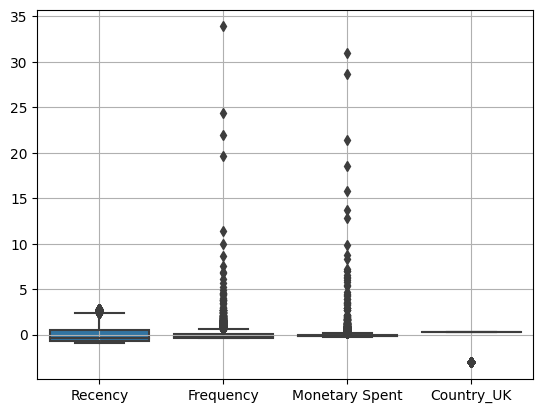

In [ ]:
# Plot scaled data
sns.boxplot(data = df_scaled)
plt.grid()
plt.show()

## Modeling

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled)
    silhouette.append(silhouette_score(X=df_scaled, labels=kmeans.labels_))

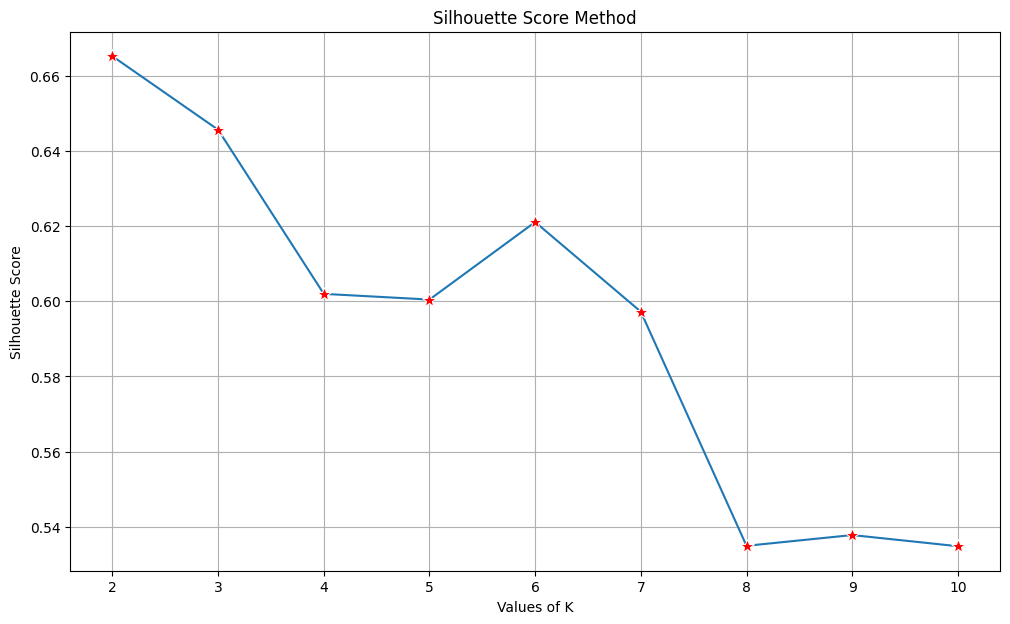

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

Using silhouette score, the best K is either 2 or 6

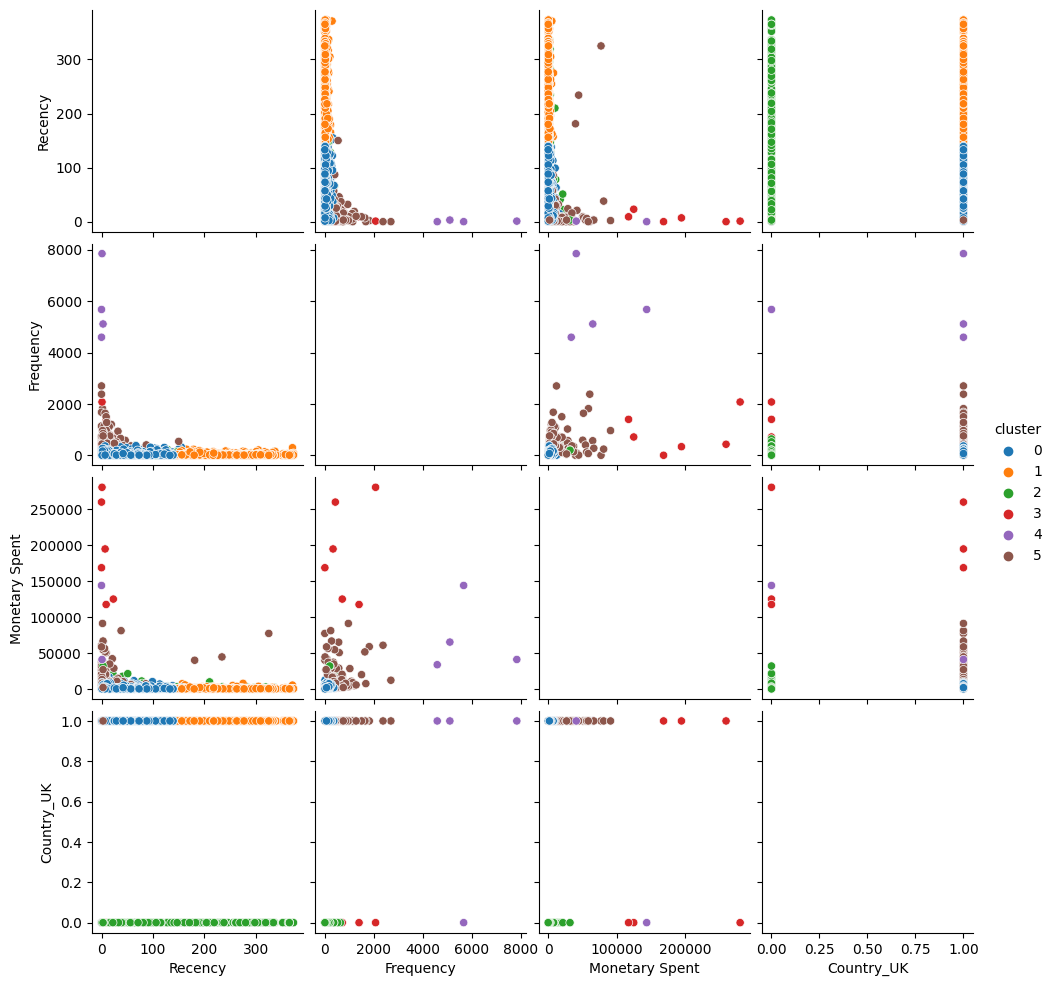

In [ ]:
kmeans = KMeans(n_clusters=6,random_state=42).fit(df_scaled)

df_result_kmeans = df_new.copy()
df_result_kmeans['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans
    .drop("Country_UK", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                           0            1             2              3  \
Recency        mean       42.676884   246.776618     95.405797       6.666667   
               std        36.313016    65.636727    104.638705       8.869423   
               min         0.000000   143.000000      0.000000       0.000000   
               q25        14.000000   189.000000     18.000000       0.250000   
               median     31.000000   242.000000     52.000000       4.000000   
               q75        64.000000   296.000000    136.500000       8.500000   
               max       155.000000   373.000000    373.000000      23.000000   
Frequency      mean       76.270826    27.689979     81.396135     826.833333   
               std        74.030983    32.176026     96.304061     771.620481   
               min         1.000000     1.000000      1.000000       3.000000   
               q25        22.000000     8.250000     21.250000     360.500000   
               median     51.000000    18.000000     45.000000     572.500000   
               q75       107.000000    33.000000    101.000000    1228.500000   
               max       385.000000   297.000000    638.000000    2076.000000   
Monetary Spent mean     1341.293935   450.793070   2262.538913  190863.461667   
               std      1592.871914   610.367153   3479.689136   67791.993010   
               min         6.200000     3.750000     51.560000  117379.630000   
               q25       371.700000   163.225000    459.650000  135804.022500   
               median    795.120000   305.515000   1025.700000  181511.645000   
               q75      1720.300000   505.542500   2659.962500  243380.672500   
               max     17654.540000  7832.470000  31906.820000  280206.020000   

cluster                            4             5  
Recency        mean         1.000000     15.234973  
               std          1.414214     35.305176  
               min          0.000000      0.000000  
               q25          0.000000      2.000000  
               median       0.500000      6.000000  
               q75          1.500000     16.000000  
               max          3.000000    325.000000  
Frequency      mean      5807.000000    535.360656  
               std       1429.730044    358.078267  
               min       4595.000000      1.000000  
               q25       4982.000000    367.000000  
               median    5393.000000    450.000000  
               q75       6218.000000    589.500000  
               max       7847.000000   2700.000000  
Monetary Spent mean     70925.287500  13085.065738  
               std      50424.336433  16313.461152  
               min      33719.730000   1093.650000  
               q25      39173.610000   4014.945000  
               median   53078.180000   6923.130000  
               q75      84829.857500  13213.210000  
               max     143825.060000  91062.380000

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Recency"].count()

cluster  Country_UK
0        1             2773
1        1              958
2        0              414
3        0                3
         1                3
4        0                1
         1                3
5        1              183
Name: Recency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Frequency"].count()

cluster  Country_UK
0        1             2773
1        1              958
2        0              414
3        0                3
         1                3
4        0                1
         1                3
5        1              183
Name: Frequency, dtype: int64

In [ ]:
df_result_kmeans.groupby(["cluster", "Country_UK"])["Monetary Spent"].count()

cluster  Country_UK
0        1             2773
1        1              958
2        0              414
3        0                3
         1                3
4        0                1
         1                3
5        1              183
Name: Monetary Spent, dtype: int64

That's it! The customer's behavior really segmented by their country of origin.

What if we separate the customer by its country of origin before doing cluster analysis?

# Question

1. (30 point) Lakukan EDA lebih mendalam dari data yang tersedia. Misalnya: a) Siapa top 5 customer dengan pembelian terbanyak? b) Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst). EDA juga bisa dilakukan menggunakan business question lain.
2. (30 point) Apa karakteristik/ciri utama dari masing-masing cluster? Apa promo yang kira-kira cocok untuk diberikan ke masing-masing cluster?
3. (40 point) Bagaimana jika segmentation difokuskan untuk customer di luar UK? Apakah terdapat insight yang menarik? Apa karakteristik utama dari cluster-cluster non UK?

#Jawaban Question 1

In [ ]:
df_jawaban = df.copy()

## A (Siapa top 5 customer dengan pembelian terbanyak?)

Cara 1


In [ ]:
top_5_customers = df_jawaban.groupby('CustomerID')['Quantity'].sum().nlargest(5)
print("Top 5 Customer dengan Pembelian Terbanyak:")
print(top_5_customers)


Top 5 Customer dengan Pembelian Terbanyak:
CustomerID
14646.0    196915
16446.0     80997
14911.0     80265
12415.0     77374
12346.0     74215
Name: Quantity, dtype: int64


Cara 2

In [ ]:
top_5_customers = df_jawaban.groupby('CustomerID')['Quantity'].sum().sort_values(ascending=False).head(5)
print("Top 5 Customer dengan Pembelian Terbanyak:")
print(top_5_customers)


Top 5 Customer dengan Pembelian Terbanyak:
CustomerID
14646.0    196915
16446.0     80997
14911.0     80265
12415.0     77374
12346.0     74215
Name: Quantity, dtype: int64


## B (Kapan waktu pembelian dengan jumlah customer terbanyak? (Misal hari apa, jam berapa, bulan apa, minggu ke berapa, dst))

In [ ]:
# # Menambahkan kolom 'Day', 'Hour', 'Month', dan 'Week'
# df_jawaban['Day'] = df_jawaban['InvoiceDate'].dt.day_name()
# df_jawaban['Hour'] = df_jawaban['InvoiceDate'].dt.hour
# df_jawaban['Month'] = df_jawaban['InvoiceDate'].dt.month_name()
# df_jawaban['Week'] = df_jawaban['InvoiceDate'].dt.isocalendar().week

# # Analisis Berdasarkan Hari
# customer_count_by_day = df_jawaban['CustomerID'].groupby(df_jawaban['Day']).nunique()
# most_customers_day = customer_count_by_day.idxmax()
# print(f"Hari dengan Jumlah Customer Terbanyak: {most_customers_day}")

# # Analisis Berdasarkan Jam
# customer_count_by_hour = df_jawaban['CustomerID'].groupby(df_jawaban['Hour']).nunique()
# most_customers_hour = customer_count_by_hour.idxmax()
# print(f"Jam dengan Jumlah Customer Terbanyak: {most_customers_hour}")

# # Analisis Berdasarkan Bulan
# customer_count_by_month = df_jawaban['CustomerID'].groupby(df_jawaban['Month']).nunique()
# most_customers_month = customer_count_by_month.idxmax()
# print(f"Bulan dengan Jumlah Customer Terbanyak: {most_customers_month}")

# # Analisis Berdasarkan Minggu
# customer_count_by_week = df_jawaban['CustomerID'].groupby(df_jawaban['Week']).nunique()
# most_customers_week = customer_count_by_week.idxmax()
# print(f"Minggu dengan Jumlah Customer Terbanyak: {most_customers_week}")


In [ ]:
def analyze_purchase_time(df, title):
    # Menambahkan kolom 'Day', 'Hour', 'Month', dan 'Week'
    df_analysis = df.copy()
    df_analysis['Day'] = df['InvoiceDate'].dt.day_name()
    df_analysis['Hour'] = df['InvoiceDate'].dt.hour
    df_analysis['Month'] = df['InvoiceDate'].dt.month_name()
    df_analysis['Week'] = df['InvoiceDate'].dt.isocalendar().week

    # Analisis Berdasarkan Hari
    customer_count_by_day = df['CustomerID'].groupby(df_analysis['Day']).nunique()
    most_customers_day = customer_count_by_day.idxmax()
    print(f"{title} - Hari dengan Jumlah Customer Terbanyak: {most_customers_day}")

    # Analisis Berdasarkan Jam
    customer_count_by_hour = df['CustomerID'].groupby(df_analysis['Hour']).nunique()
    most_customers_hour = customer_count_by_hour.idxmax()
    print(f"{title} - Jam dengan Jumlah Customer Terbanyak: {most_customers_hour}")

    # Analisis Berdasarkan Bulan
    customer_count_by_month = df['CustomerID'].groupby(df_analysis['Month']).nunique()
    most_customers_month = customer_count_by_month.idxmax()
    print(f"{title} - Bulan dengan Jumlah Customer Terbanyak: {most_customers_month}")

    # Analisis Berdasarkan Minggu
    customer_count_by_week = df['CustomerID'].groupby(df_analysis['Week']).nunique()
    most_customers_week = customer_count_by_week.idxmax()
    print(f"{title} - Minggu dengan Jumlah Customer Terbanyak: {most_customers_week}")

# Analisis untuk UK
analyze_purchase_time(df_jawaban, "UK")


UK - Hari dengan Jumlah Customer Terbanyak: Thursday
UK - Jam dengan Jumlah Customer Terbanyak: 12
UK - Bulan dengan Jumlah Customer Terbanyak: November
UK - Minggu dengan Jumlah Customer Terbanyak: 48


idxmax merupakan metode pada pandas yang digunakan untuk mengembalikan indeks dari nilai maksimum.

## Apakah Pola Pembelian Berubah dari Hari ke Hari?

In [ ]:
# Menambahkan kolom 'Day', 'Hour', 'Month', dan 'Week'
df_jawaban['Day'] = df_jawaban['InvoiceDate'].dt.day_name()
df_jawaban['Hour'] = df_jawaban['InvoiceDate'].dt.hour
df_jawaban['Month'] = df_jawaban['InvoiceDate'].dt.month_name()
df_jawaban['Week'] = df_jawaban['InvoiceDate'].dt.isocalendar().week

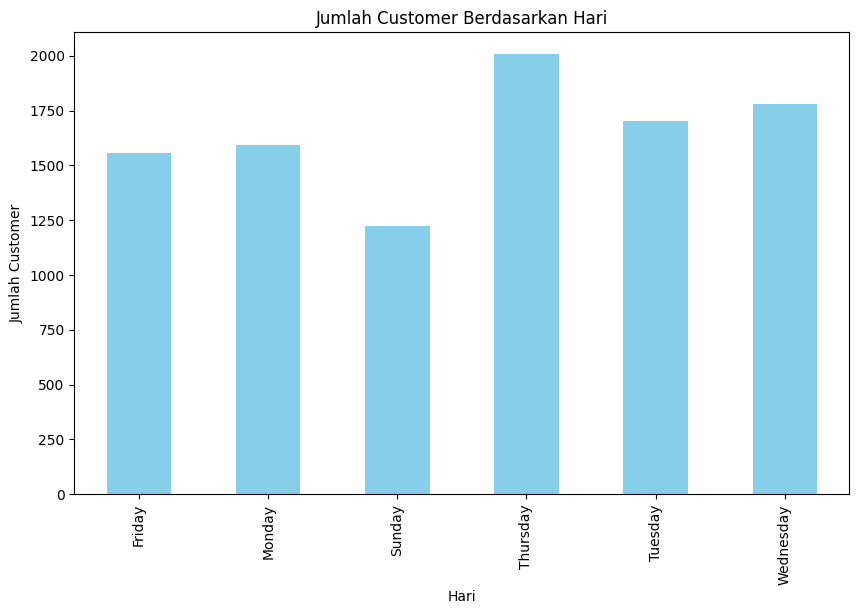

In [ ]:
# Menghitung jumlah customer untuk setiap hari
customer_count_by_day = df_jawaban['CustomerID'].groupby(df_jawaban['Day']).nunique()

# Visualisasi
plt.figure(figsize=(10, 6))
customer_count_by_day.plot(kind='bar', color='skyblue')
plt.title('Jumlah Customer Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Customer')
plt.show()

Pembelian tertinggi di hari kamis, diikuti dengan selasa dan rabu. Ternyata pada weekend terdapat penurunan

## Apakah Ada Tren Pembelian Berdasarkan Jam?

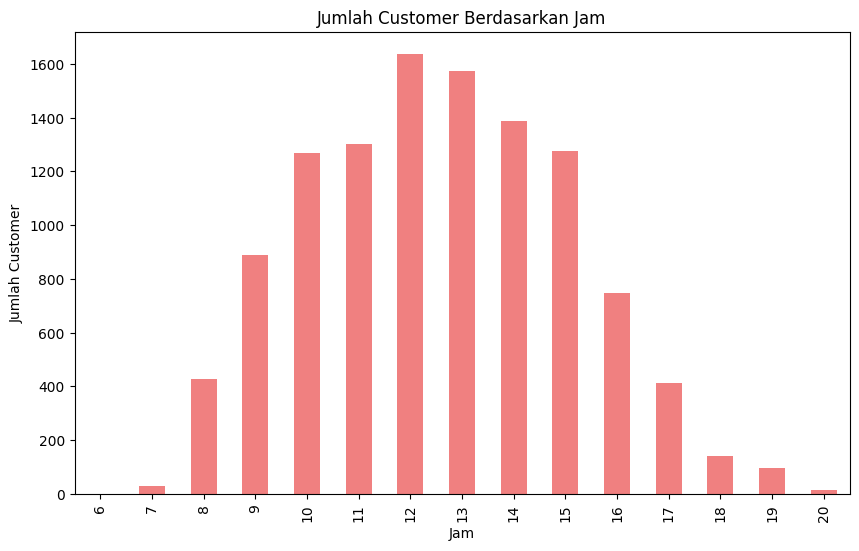

In [ ]:
# Menghitung jumlah customer untuk setiap jam
customer_count_by_hour = df_jawaban['CustomerID'].groupby(df_jawaban['Hour']).nunique()

# Visualisasi
plt.figure(figsize=(10, 6))
customer_count_by_hour.plot(kind='bar', color='lightcoral')
plt.title('Jumlah Customer Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Customer')
plt.show()


Terdapat kenaikan yang signifikan setelah jam 7. Berarti jam produktif untuk jualan yaitu jam 10-15

## Apakah Ada Perbedaan Pola Pembelian antara Bulan-Bulan Tertentu?

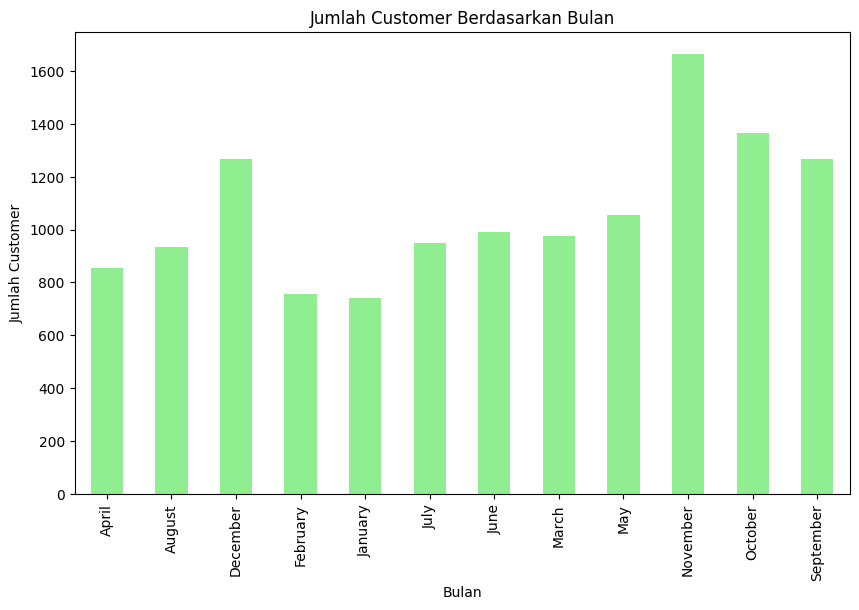

In [ ]:
# Menghitung jumlah customer untuk setiap bulan
customer_count_by_month = df_jawaban['CustomerID'].groupby(df_jawaban['Month']).nunique()

# Visualisasi
plt.figure(figsize=(10, 6))
customer_count_by_month.plot(kind='bar', color='lightgreen')
plt.title('Jumlah Customer Berdasarkan Bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah Customer')
plt.show()

Pembelian pada akhir tahun yang paling tinggi dan meningkat mulai dari bulan September hingga November




## Bagaimana Perkembangan Pembelian dari Minggu ke Minggu?

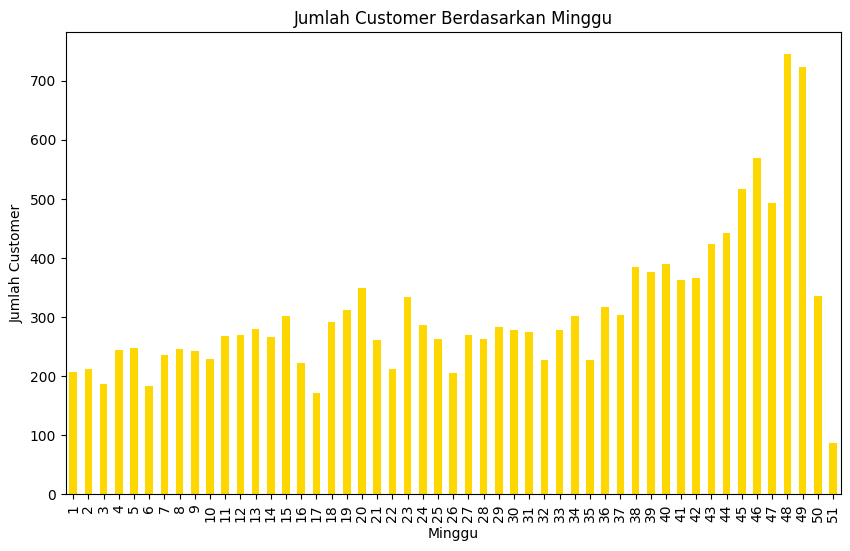

In [ ]:
# Menghitung jumlah customer untuk setiap minggu
customer_count_by_week = df_jawaban['CustomerID'].groupby(df_jawaban['Week']).nunique()

# Visualisasi
plt.figure(figsize=(10, 6))
customer_count_by_week.plot(kind='bar', color='gold')
plt.title('Jumlah Customer Berdasarkan Minggu')
plt.xlabel('Minggu')
plt.ylabel('Jumlah Customer')
plt.show()

Sesuai dengan chart-chart sebelumnya bahwa akhir tahun mengalami kenaikan yang signifikan. dimulai dari Minggu 37

## Produk yang Paling Sering Dibeli & Produk dengan Total Nilai Pembelian Tertinggi


In [ ]:
# 1. Produk yang Paling Sering Dibeli
most_purchased_products = df_jawaban.groupby(['StockCode', 'Description'])['Quantity'].sum().nlargest(5).reset_index()
most_purchased_products.head()



,StockCode,Description,Quantity
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916
2,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
3,85099B,JUMBO BAG RED RETROSPOT,46181
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,36725


In [ ]:
# 2. Produk dengan Total Nilai Pembelian Tertinggi
df_jawaban['TotalAmount'] = df_jawaban['Quantity'] * df_jawaban['UnitPrice']
total_value_per_product = df_jawaban.groupby(['StockCode', 'Description'])['TotalAmount'].sum().nlargest(5).reset_index()
total_value_per_product.head()

,StockCode,Description,TotalAmount
0,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,22423,REGENCY CAKESTAND 3 TIER,142592.95
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,100448.15
3,85099B,JUMBO BAG RED RETROSPOT,85220.78
4,23166,MEDIUM CERAMIC TOP STORAGE JAR,81416.73


## Segmentasi Pelanggan

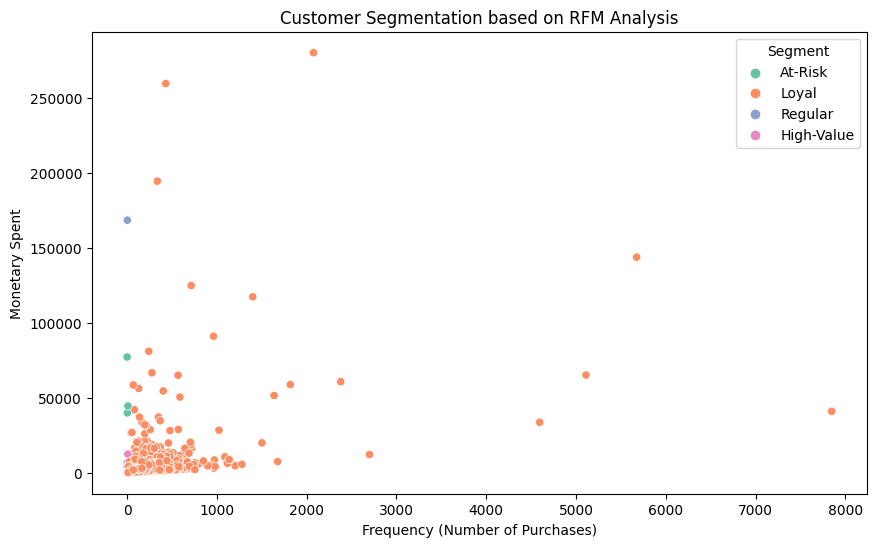

In [ ]:
# Define criteria for segmentation
high_value_criteria = (df_new['Recency'] <= 30) & (df_new['Frequency'] >= 5) & (df_new['Monetary Spent'] >= 1000)
loyal_criteria = (df_new['Frequency'] >= 10)
at_risk_criteria = (df_new['Recency'] > 180)

# Apply segmentation labels
df_new['Segment'] = 'Regular'
df_new.loc[high_value_criteria, 'Segment'] = 'High-Value'
df_new.loc[loyal_criteria, 'Segment'] = 'Loyal'
df_new.loc[at_risk_criteria, 'Segment'] = 'At-Risk'

# Visualize the segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary Spent', hue='Segment', data=df_new, palette='Set2')
plt.title('Customer Segmentation based on RFM Analysis')
plt.xlabel('Frequency (Number of Purchases)')
plt.ylabel('Monetary Spent')
plt.show()


#Jawaban Question 2


**Cluster 0:**
- *Karakteristik Utama:*
  - Recency rata-rata rendah (42.68), Frequency tinggi (76.27), Monetary Spent sedang (1341.29).
  - Tren pembelian relatif baru.
- *Promo yang Cocok:*
  - Promo Program Loyalitas: Memberikan reward atau poin untuk setiap pembelian, dengan penawaran khusus untuk pelanggan yang sering berbelanja.

**Cluster 1:**
- *Karakteristik Utama:*
  - Recency rata-rata tinggi (246.78), Frequency rendah (27.69), Monetary Spent rendah (450.79).
  - Tren pembelian cenderung kurang aktif.
- *Promo yang Cocok:*
  - Diskon Khusus: Menawarkan diskon eksklusif atau penawaran istimewa untuk meningkatkan frekuensi pembelian.

**Cluster 2:**
- *Karakteristik Utama:*
  - Recency rata-rata menengah (95.41), Frequency tinggi (81.40), Monetary Spent tinggi (2262.54).
  - Pembelian relatif baru, tetapi dengan nilai yang signifikan.
- *Promo yang Cocok:*
  - Promo Bundle: Membuat paket bundel produk dengan harga spesial untuk meningkatkan nilai transaksi.
  - Diskon Tambahan: Memberikan diskon tambahan untuk setiap pembelian dalam jumlah tertentu.

**Cluster 3:**
- *Karakteristik Utama:*
  - Recency rata-rata sangat rendah (6.67), Frequency sangat tinggi (826.83), Monetary Spent sangat tinggi (190863.46).
  - Tren pembelian sangat aktif dan nilai transaksi tinggi.
- *Promo yang Cocok:*
  - Program VIP: Program eksklusif VIP dengan reward khusus, diskon besar, atau akses ke produk atau acara eksklusif.

**Cluster 4:**
- *Karakteristik Utama:*
  - Recency rata-rata sangat rendah (1.00), Frequency sangat tinggi (5807.00), Monetary Spent tinggi (70925.29).
  - Pembelian sangat baru dan dengan nilai transaksi yang tinggi.
- *Promo yang Cocok:*
  - Program Loyalitas Tingkat Tinggi: Program loyalitas tingkat tinggi dengan hadiah eksklusif, diskon tambahan, atau akses ke penawaran khusus.

**Cluster 5:**
- *Karakteristik Utama:*
  - Recency rata-rata rendah (15.23), Frequency tinggi (535.36), Monetary Spent sedang (13085.07).
  - Pembelian relatif baru dengan nilai yang cukup tinggi.
- *Promo yang Cocok:*
  - Promo Produk Spesial: Menawarkan diskon atau penawaran spesial untuk produk tertentu yang sering dibeli oleh cluster ini.
  - Diskon Kategori: Memberikan diskon khusus untuk kategori produk yang sering dibeli.


#Jawaban Question 3

In [ ]:
df_non_uk = df.copy()

In [ ]:
# Filter data pelanggan di luar UK
df_non_uk = df_non_uk[df_non_uk['Country_isUK'] == 'Non UK']

df_non_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Country_isUK,TotalAmount
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,90.0
27,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,90.0
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,Non UK,45.0
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France,Non UK,10.2
30,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France,Non UK,15.6


In [ ]:
df_non_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43563 entries, 26 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceNo     43563 non-null  object        
 1   StockCode     43563 non-null  object        
 2   Description   43563 non-null  object        
 3   Quantity      43563 non-null  int64         
 4   InvoiceDate   43563 non-null  datetime64[ns]
 5   UnitPrice     43563 non-null  float64       
 6   CustomerID    43563 non-null  float64       
 7   Country       43563 non-null  object        
 8   Country_isUK  43563 non-null  object        
 9   TotalAmount   43563 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 3.7+ MB


## EDA

### Weekly Trend

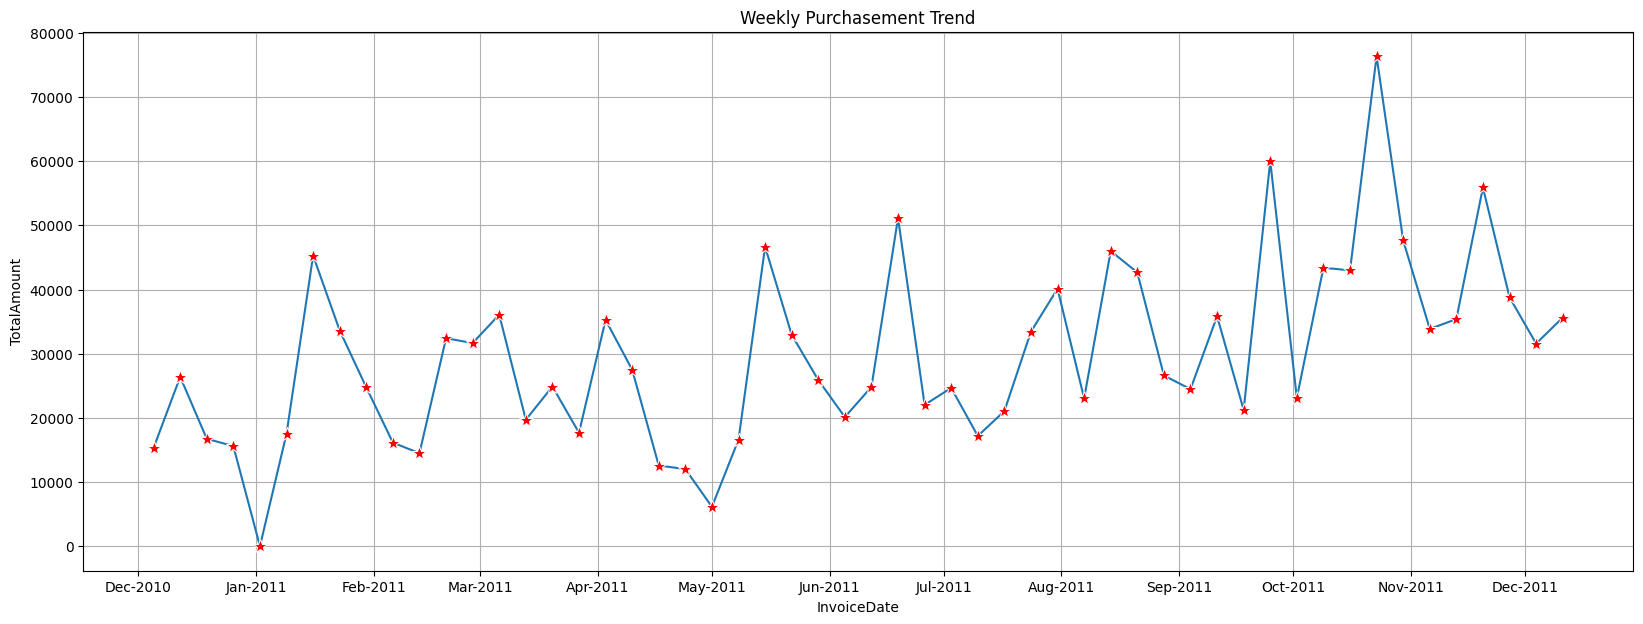

In [ ]:
# Plot weekly trend
weekly_purchasements_non_uk = df_non_uk.copy()
weekly_purchasements_non_uk = weekly_purchasements_non_uk.groupby(
    by=pd.Grouper(key="InvoiceDate", freq="1W"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Weekly Purchasement Trend')
ax = sns.lineplot(
    x=weekly_purchasements_non_uk.index,
    y=weekly_purchasements_non_uk,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

### Monthly Trend

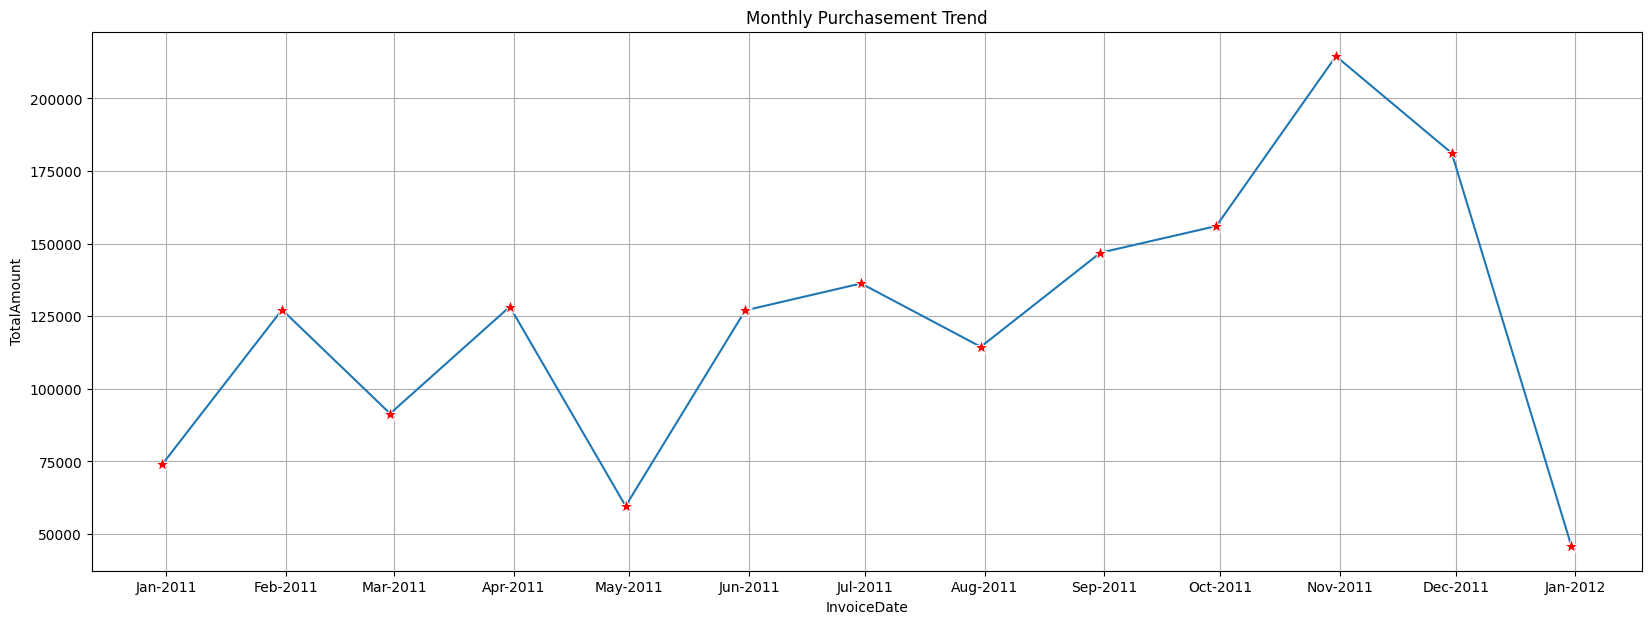

In [ ]:
# Plot monthly trend
monthly_purchasements_non_uk = df_non_uk.copy()
monthly_purchasements_non_uk = monthly_purchasements_non_uk.groupby(by = pd.Grouper(key="InvoiceDate", freq="1M"))["TotalAmount"].sum()

plt.figure(figsize=(20, 7))
plt.title('Monthly Purchasement Trend')
ax = sns.lineplot(
    x=monthly_purchasements_non_uk.index,
    y=monthly_purchasements_non_uk,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.grid()
plt.show();

Kurang lebih sama dengan Country UK, mengalami kenaikan hingga akhir tahun. Akan tetapi perbedaannya terdapat pada puncak Purchasement nya di bulan November setelah itu mengalami penurunan

### Distribusi Jumlah Pembelian

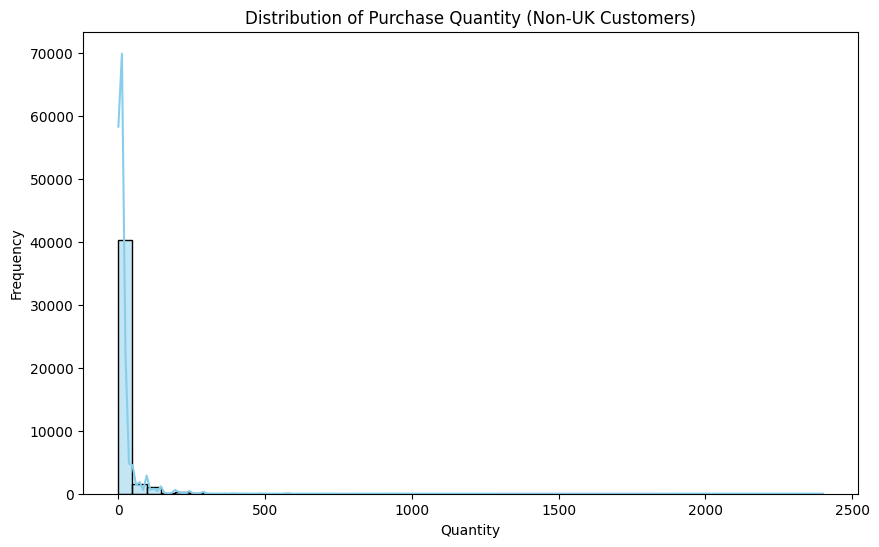

In [ ]:
# Visualisasi distribusi jumlah pembelian
plt.figure(figsize=(10, 6))
sns.histplot(df_non_uk['Quantity'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Purchase Quantity (Non-UK Customers)')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Statistik deskriptif jumlah pembelian
quantity_stats = df_non_uk['Quantity'].describe()
print(quantity_stats)

count    43563.000000
mean        20.913895
std         47.964991
min          1.000000
25%          6.000000
50%         12.000000
75%         18.000000
max       2400.000000
Name: Quantity, dtype: float64


Dari statistik deskriptif jumlah pembelian (Quantity) pelanggan di luar UK, dapat diambil beberapa insight penting:

1. **Rata-rata Pembelian:** Rata-rata jumlah pembelian per transaksi adalah sekitar 20.91 barang.

2. **Variatibilitas Tinggi:** Standar deviasi yang relatif tinggi (47.96) menunjukkan bahwa terdapat variasi yang signifikan dalam jumlah barang yang dibeli oleh pelanggan. Sebagian besar transaksi memiliki jumlah pembelian yang jauh lebih rendah dari nilai rata-rata, tetapi ada beberapa transaksi yang memiliki jumlah pembelian yang sangat tinggi (maksimum 2400).

3. **Pembelian Minimum dan Maksimum:** Pembelian terkecil adalah 1 barang, sementara pembelian terbesar mencapai 2400 barang. Perbedaan antara nilai minimum dan maksimum yang signifikan menunjukkan variasi yang besar dalam skala pembelian.

4. **Kuartil:** Kuartil pertama (Q1) sebesar 6, kuartil kedua (median atau Q2) sebesar 12, dan kuartil ketiga (Q3) sebesar 18. Ini memberikan gambaran tentang distribusi jumlah pembelian dan seberapa sering pelanggan melakukan pembelian dalam jumlah tertentu.

Dengan demikian, distribusi jumlah pembelian pelanggan di luar UK memiliki karakteristik variasi yang tinggi, dengan sebagian besar transaksi memiliki jumlah pembelian yang relatif kecil, tetapi beberapa transaksi memiliki jumlah pembelian yang sangat tinggi.


### Produk Paling Sering Dibeli:

In [ ]:
most_purchased_products.head()

,StockCode,Description,Quantity
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,77916
2,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
3,85099B,JUMBO BAG RED RETROSPOT,46181
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,36725


In [ ]:
# 1. Produk yang Paling Sering Dibeli
most_purchased_products_non_uk = df_non_uk.groupby(['StockCode', 'Description'])['Quantity'].sum().nlargest(5).reset_index()
most_purchased_products_non_uk.head()

,StockCode,Description,Quantity
0,23084,RABBIT NIGHT LIGHT,15437
1,22492,MINI PAINT SET VINTAGE,12493
2,21212,PACK OF 72 RETROSPOT CAKE CASES,11228
3,22629,SPACEBOY LUNCH BOX,8364
4,22630,DOLLY GIRL LUNCH BOX,7344


Terdapat perbedaan pada produk yang paling sering dibeli pada UK dan NON UK

### Distribusi Total Pengeluaran

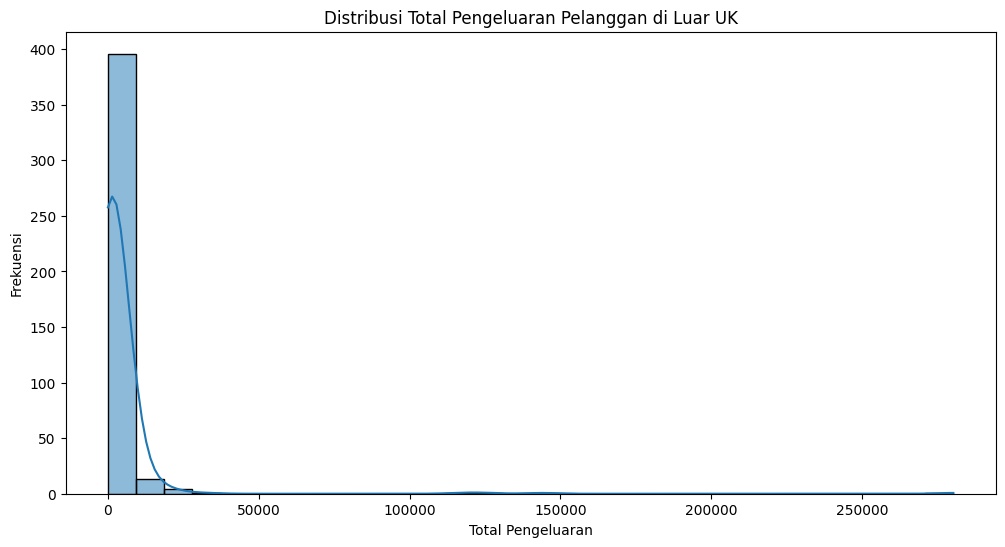

In [ ]:
# Hitung total pengeluaran untuk setiap pelanggan
customer_total_spending = df_non_uk.groupby('CustomerID')['TotalAmount'].sum()

# Visualisasikan distribusi total pengeluaran
plt.figure(figsize=(12, 6))
sns.histplot(customer_total_spending, bins=30, kde=True)
plt.title('Distribusi Total Pengeluaran Pelanggan di Luar UK')
plt.xlabel('Total Pengeluaran')
plt.ylabel('Frekuensi')
plt.show()

### Analisis Waktu Pembelian

#### Hari

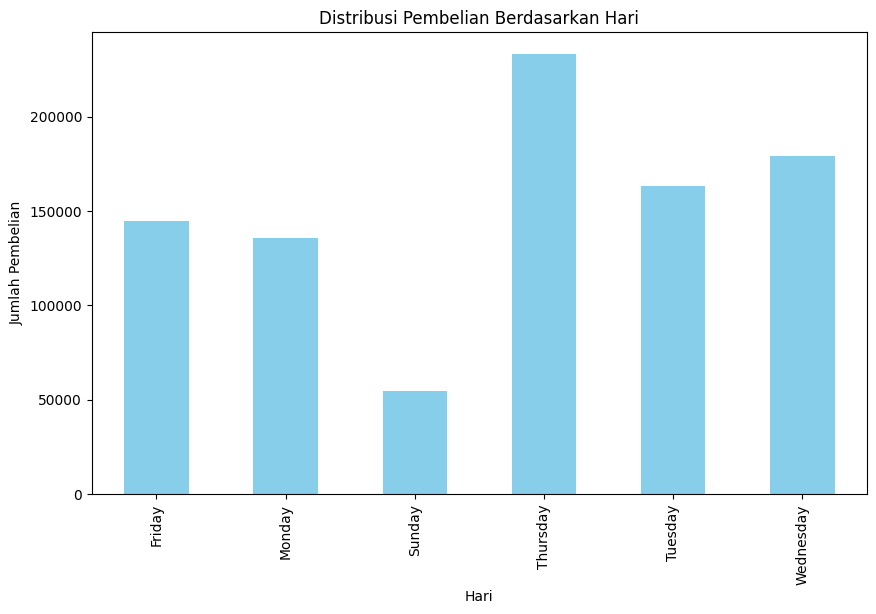

In [ ]:
# Analisis Pembelian Berdasarkan Hari
purchase_by_day = df_non_uk.groupby(df_non_uk['InvoiceDate'].dt.day_name())['Quantity'].sum()

# Visualisasi
plt.figure(figsize=(10, 6))
purchase_by_day.plot(kind='bar', color='skyblue')
plt.title('Distribusi Pembelian Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Pembelian')
plt.show()

Polanya Sama dengan Negara UK, hari kamis merupakan hari terbanyak untuk pembelian, diikuti dengan selasa dan rabu. Pada weekend mengalami penurunan

#### Jam

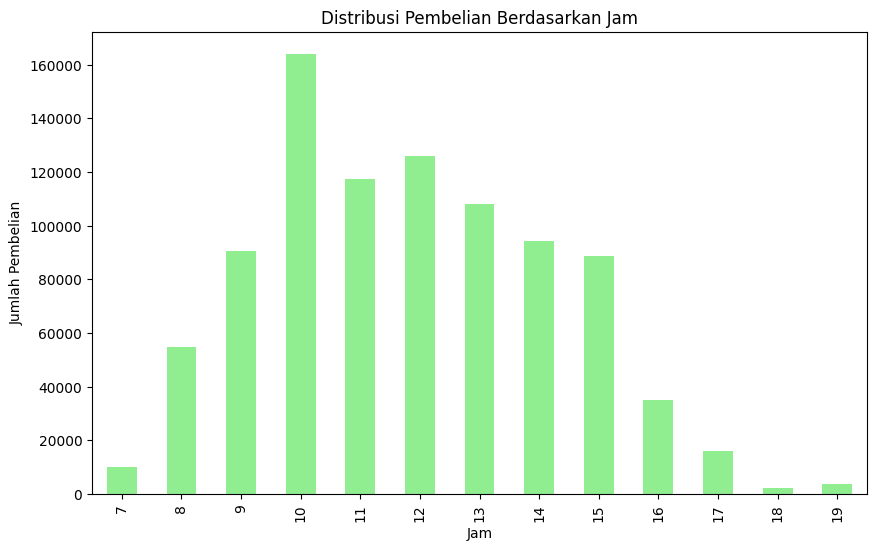

In [ ]:
# Analisis Pembelian Berdasarkan Jam
purchase_by_hour = df_non_uk.groupby(df_non_uk['InvoiceDate'].dt.hour)['Quantity'].sum()

# Visualisasi
plt.figure(figsize=(10, 6))
purchase_by_hour.plot(kind='bar', color='lightgreen')
plt.title('Distribusi Pembelian Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Pembelian')
plt.show()

Polanya sama dengan Negara UK, terdapat kenaikan yang signifikan setelah jam 7. Akan tetapi terdapat perbedaan yaitu puncak pembelian terbanyak di jam 10

### Pembelian Terbanyak


In [ ]:
# Analisis untuk Non-UK
analyze_purchase_time(df_jawaban, "UK")
analyze_purchase_time(df_non_uk, "Non-UK")

UK - Hari dengan Jumlah Customer Terbanyak: Thursday
UK - Jam dengan Jumlah Customer Terbanyak: 12
UK - Bulan dengan Jumlah Customer Terbanyak: November
UK - Minggu dengan Jumlah Customer Terbanyak: 48
Non-UK - Hari dengan Jumlah Customer Terbanyak: Thursday
Non-UK - Jam dengan Jumlah Customer Terbanyak: 10
Non-UK - Bulan dengan Jumlah Customer Terbanyak: November
Non-UK - Minggu dengan Jumlah Customer Terbanyak: 48


Perbedaan hanya terdapat pada Jam

In [ ]:
# # Buat DataFrame baru tanpa menambahkan kolom ke df_non_uk
# df_non_uk_analysis = df_non_uk.copy()

# # Tambahkan kolom 'Day', 'Hour', 'Month', dan 'Week' pada DataFrame baru
# df_non_uk_analysis['Day'] = df_non_uk['InvoiceDate'].dt.day_name()
# df_non_uk_analysis['Hour'] = df_non_uk['InvoiceDate'].dt.hour
# df_non_uk_analysis['Month'] = df_non_uk['InvoiceDate'].dt.month_name()
# df_non_uk_analysis['Week'] = df_non_uk['InvoiceDate'].dt.isocalendar().week

# # Analisis Berdasarkan Hari
# customer_count_by_day_non_uk = df_non_uk['CustomerID'].groupby(df_non_uk_analysis['Day']).nunique()
# most_customers_day_non_uk = customer_count_by_day_non_uk.idxmax()
# print(f"Hari dengan Jumlah Customer Terbanyak di Non-UK: {most_customers_day_non_uk}")

# # Analisis Berdasarkan Jam
# customer_count_by_hour_non_uk = df_non_uk['CustomerID'].groupby(df_non_uk_analysis['Hour']).nunique()
# most_customers_hour_non_uk = customer_count_by_hour_non_uk.idxmax()
# print(f"Jam dengan Jumlah Customer Terbanyak di Non-UK: {most_customers_hour_non_uk}")

# # Analisis Berdasarkan Bulan
# customer_count_by_month_non_uk = df_non_uk['CustomerID'].groupby(df_non_uk_analysis['Month']).nunique()
# most_customers_month_non_uk = customer_count_by_month_non_uk.idxmax()
# print(f"Bulan dengan Jumlah Customer Terbanyak di Non-UK: {most_customers_month_non_uk}")

# # Analisis Berdasarkan Minggu
# customer_count_by_week_non_uk = df_non_uk['CustomerID'].groupby(df_non_uk_analysis['Week']).nunique()
# most_customers_week_non_uk = customer_count_by_week_non_uk.idxmax()
# print(f"Minggu dengan Jumlah Customer Terbanyak di Non-UK: {most_customers_week_non_uk}")


### Analisis Perilaku Pembelian Antar Negara Non-UK

In [ ]:
# Perbandingan statistik pembelian antar negara Non-UK
purchase_stats_by_country = df_non_uk.groupby('Country')['Quantity'].describe()
purchase_stats_by_country

,count,mean,std,min,25%,50%,75%,max
Country,,,,,,,,
Australia,1182.0,70.982234,98.756102,1.0,10.00,32.0,100.0,1152.0
Austria,398.0,12.263819,21.590493,1.0,6.00,10.0,12.0,288.0
Bahrain,17.0,15.294118,24.959379,2.0,6.00,6.0,8.0,96.0
Belgium,2031.0,11.441162,13.597680,1.0,4.00,10.0,12.0,272.0
Brazil,32.0,11.125000,8.476723,2.0,3.00,10.0,18.0,24.0
Canada,151.0,18.298013,46.682587,1.0,6.00,12.0,20.0,504.0
Channel Islands,748.0,12.688503,22.665262,1.0,4.00,10.0,12.0,407.0
Cyprus,614.0,10.359935,23.315324,1.0,2.00,5.0,12.0,288.0
Czech Republic,25.0,26.840000,17.276381,1.0,18.00,24.0,24.0,72.0


**Australia:**
- Jumlah pembelian rata-rata: 70.98
- Jumlah pembelian maksimum: 1152
- Distribusi pembelian cenderung bervariasi.

**Netherlands:**
- Jumlah pembelian rata-rata: 84.93
- Jumlah pembelian maksimum: 2400
- Distribusi pembelian cenderung bervariasi.

**Sweden:**
- Jumlah pembelian rata-rata: 80.01
- Jumlah pembelian maksimum: 768
- Distribusi pembelian cenderung bervariasi.

**Japan:**
- Jumlah pembelian rata-rata: 81.05
- Jumlah pembelian maksimum: 2040
- Distribusi pembelian cenderung bervariasi.

**EIRE:**
- Jumlah pembelian rata-rata: 19.39
- Jumlah pembelian maksimum: 1440
- Distribusi pembelian cenderung bervariasi.

**Insight:**
- Beberapa negara Non-UK memiliki rata-rata pembelian yang tinggi dengan distribusi pembelian yang relatif stabil, seperti Netherlands dan Sweden.
- Negara seperti Australia menunjukkan variasi yang signifikan dalam perilaku pembelian, dengan rentang pembelian yang luas dari minimum hingga maksimum.
- Jepang memiliki rata-rata pembelian yang tinggi, namun dengan variasi yang sangat besar dalam pembelian, terlihat dari nilai maksimum yang mencapai 2040.
- EIRE memiliki rata-rata pembelian yang cukup tinggi dengan variasi yang signifikan.


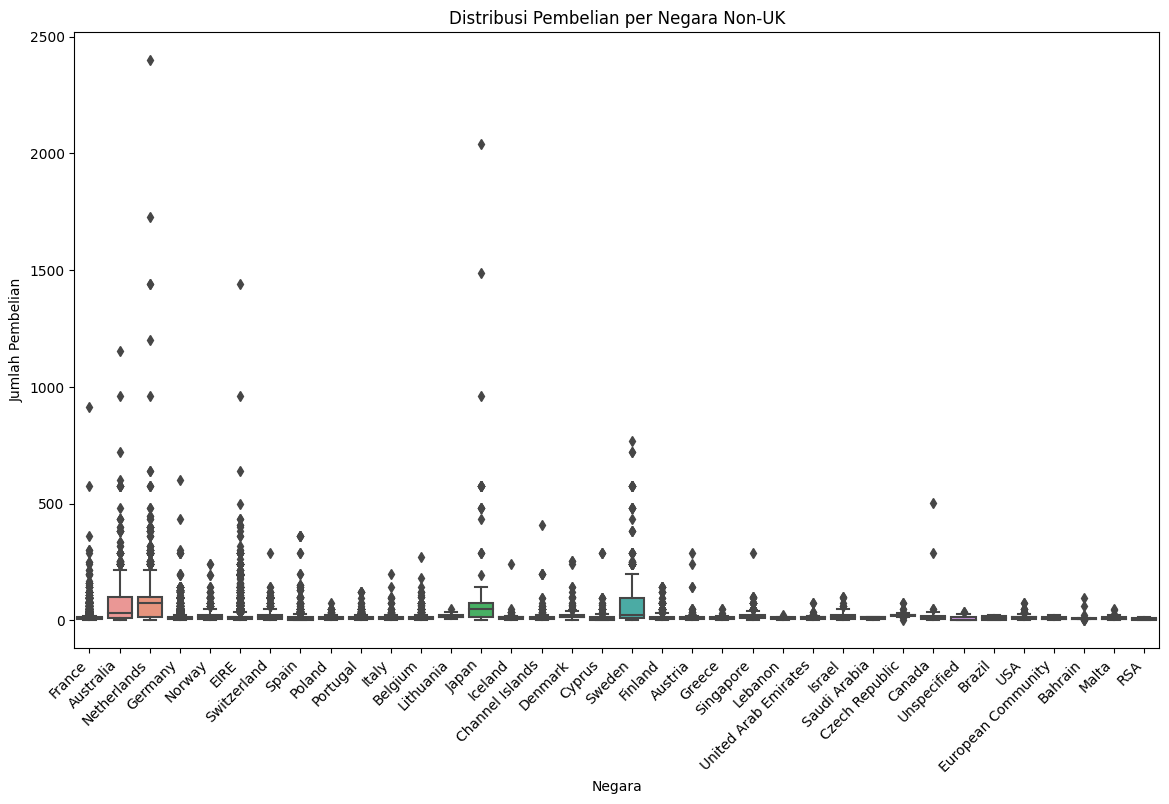

In [ ]:
# Visualisasi distribusi pembelian antar negara Non-UK dengan boxplot
plt.figure(figsize=(14, 8))
sns.boxplot(x='Country', y='Quantity', data=df_non_uk)
plt.title('Distribusi Pembelian per Negara Non-UK')
plt.xlabel('Negara')
plt.ylabel('Jumlah Pembelian')
plt.xticks(rotation=45, ha='right')
plt.show()


### Distribusi Pelanggan di Setiap Negara Non-UK

In [ ]:
# Jumlah pelanggan per negara Non-UK
customer_count_by_country = df_non_uk.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)
print(customer_count_by_country)


Country
Germany                 94
France                  87
Spain                   30
Belgium                 25
Switzerland             21
Portugal                19
Italy                   14
Finland                 12
Austria                 11
Norway                  10
Netherlands              9
Australia                9
Channel Islands          9
Denmark                  9
Cyprus                   8
Sweden                   8
Japan                    8
Poland                   6
USA                      4
Canada                   4
Unspecified              4
Greece                   4
EIRE                     3
Israel                   3
Malta                    2
Bahrain                  2
United Arab Emirates     2
Lithuania                1
Lebanon                  1
Czech Republic           1
RSA                      1
Saudi Arabia             1
Singapore                1
Brazil                   1
Iceland                  1
European Community       1
Name: CustomerID, dt

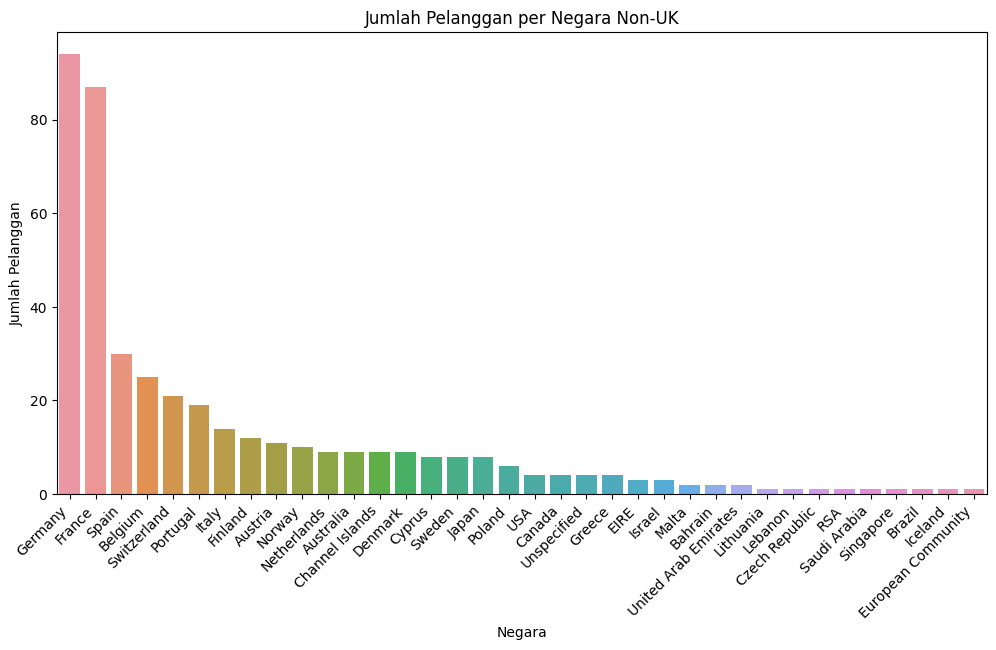

In [ ]:
# Visualisasi distribusi pelanggan per negara Non-UK
plt.figure(figsize=(12, 6))
sns.barplot(x=customer_count_by_country.index, y=customer_count_by_country.values)
plt.title('Jumlah Pelanggan per Negara Non-UK')
plt.xlabel('Negara')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45, ha='right')
plt.show()


NON UK didominasi oleh negara di Eropa

## Recency

In [ ]:
# # Get customer's recency
# recency_non_uk = df_non_uk.groupby(['CustomerID'])['InvoiceDate'].max()
# recency_non_uk = max(recency_non_uk) - recency_non_uk
# recency_non_uk = recency_non_uk.dt.days
# recency_non_uk = recency_non_uk.rename('Recency')

# recency_non_uk.head()

In [ ]:
# Hitung recency
recency_non_uk = df_non_uk.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_non_uk['Recency'] = (pd.to_datetime('now') - recency_non_uk['InvoiceDate']).dt.days
recency_non_uk = recency_non_uk[['CustomerID', 'Recency']]

recency_non_uk.head()

,CustomerID,Recency
0,12347.0,4370
1,12348.0,4443
2,12349.0,4386
3,12350.0,4678
4,12352.0,4404


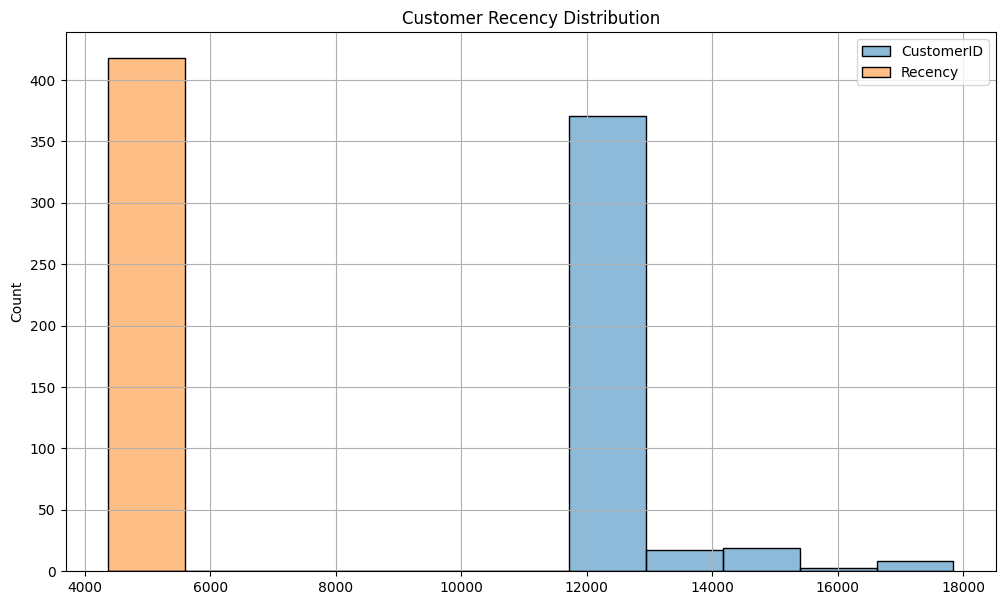

In [ ]:
# Recency histogram plot
plt.figure(figsize=(12, 7))
sns.histplot(recency_non_uk)
plt.title('Customer Recency Distribution')
plt.grid()
plt.show()

## Frequency

In [ ]:
# # Count frequency
# frequency_non_uk = df_non_uk.groupby(['CustomerID'])['InvoiceNo'].count()
# frequency_non_uk = frequency_non_uk.rename('Frequency')
# frequency_non_uk.head()


In [ ]:
# Hitung frequency
frequency_non_uk = df_non_uk.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_non_uk.columns = ['CustomerID', 'Frequency']

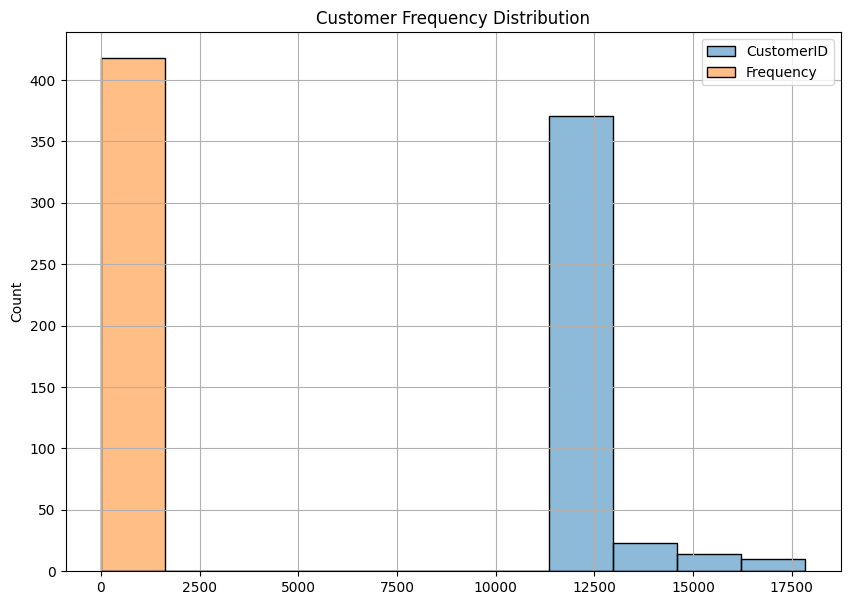

In [ ]:
# Frequency histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Frequency Distribution')
sns.histplot(frequency_non_uk)
plt.grid()
plt.show();

## Monetary

In [ ]:
# # Sum the money spent
# monetary_non_uk = df_non_uk.groupby(['CustomerID'])['TotalAmount'].sum()
# monetary_non_uk = monetary_non_uk.rename('Monetary Spent')
# monetary_non_uk.head()


In [ ]:
# Hitung monetary
monetary_non_uk = df_non_uk.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetary_non_uk.columns = ['CustomerID', 'Monetary']

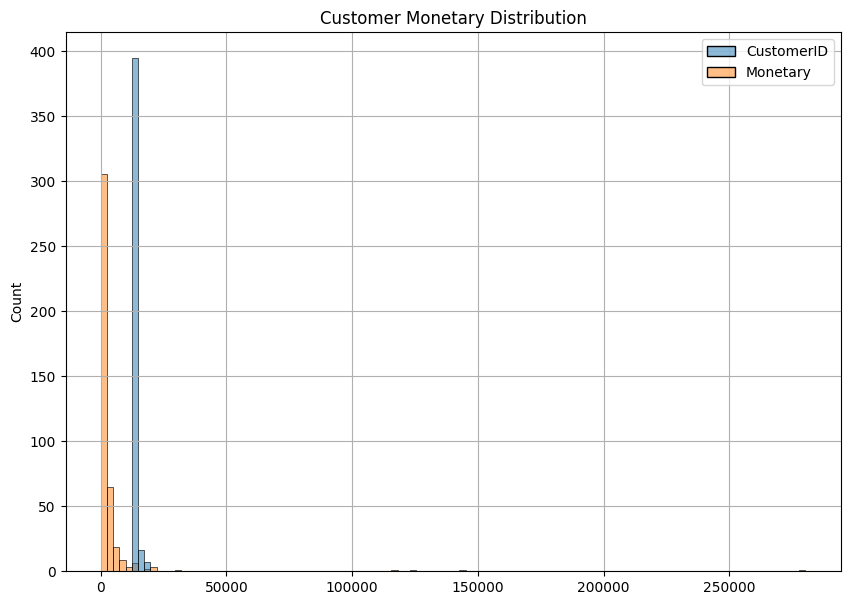

In [ ]:
# Monetary histogram plot
plt.figure(figsize=(10, 7))
plt.title('Customer Monetary Distribution')
sns.histplot(monetary_non_uk)
plt.grid()
plt.show()

## Merge the Data

In [ ]:
# # Get customer's country of origin
# country_no_uk = (
#     df_non_uk.groupby(['CustomerID', 'Country_isUK'])
#     .size()
#     .reset_index()
#     .drop(0, axis=1)
# )#chaining method

# # Merge the data
# df_rfm_non_uk = (
#   country_no_uk
#   .merge(recency_non_uk, on='CustomerID')
#   .merge(frequency_non_uk, on='CustomerID')
#   .merge(monetary_non_uk, on='CustomerID')
# )

# # Set CustomerID as index
# df_rfm_non_uk = df_rfm_non_uk.set_index('CustomerID')
# df_rfm_non_uk.head()


In [ ]:
# Gabungkan dataframe recency, frequency, dan monetary
df_rfm_non_uk = recency_non_uk.merge(frequency_non_uk, on='CustomerID')
df_rfm_non_uk = df_rfm_non_uk.merge(monetary_non_uk, on='CustomerID')

In [ ]:
df_rfm_non_uk.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,4370,7,4310.00
1,12348.0,4443,4,1797.24
2,12349.0,4386,1,1757.55
3,12350.0,4678,1,334.40
4,12352.0,4404,8,2506.04


## One Hot Encoding

In [ ]:
# # Recode the non numeric variable

# df_rfm_non_uk = pd.get_dummies(df_rfm_non_uk)

In [ ]:
# df_rfm_non_uk.head()

In [ ]:
# df_rfm_non_uk = df_rfm_non_uk.rename(
#     columns={'Country_isUK_Non UK': 'Country_nonUK'}
# )

# df_rfm_non_uk.head()

## Scaling

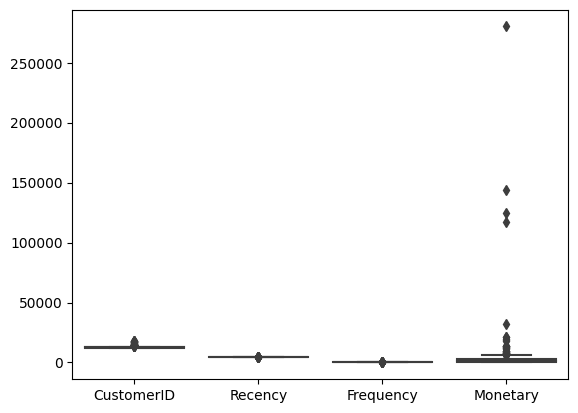

In [ ]:
sns.boxplot(data=df_rfm_non_uk)
plt.show()

In [ ]:
# # Pisahkan kolom Country_nonUK
# country_nonuk = df_rfm_non_uk['Country_nonUK']
# df_rfm_non_uk_no_country = df_rfm_non_uk.drop('Country_nonUK', axis=1)

In [ ]:
# # Scale the data

# scaler = StandardScaler()
# df_scaled_non_uk = scaler.fit_transform(df_rfm_non_uk_no_country)

# df_scaled_non_uk = pd.DataFrame(
#     df_scaled_non_uk,
#     columns=df_rfm_non_uk_no_country.columns,
#     index=df_rfm_non_uk_no_country.index
# )

# df_scaled_non_uk.head()

In [ ]:
rfm_data = df_rfm_non_uk[['Recency', 'Frequency', 'Monetary']]

In [ ]:
scaler = StandardScaler()
rfm_standardized = scaler.fit_transform(rfm_data)

In [ ]:
df_rfm_standardized_non_uk = pd.DataFrame(rfm_standardized, columns=['Recency', 'Frequency', 'Monetary'])
# df_rfm_standardized_non_uk['CustomerID'] = df_rfm_non_uk['CustomerID']

In [ ]:
df_rfm_standardized_non_uk.head()


,Recency,Frequency,Monetary
0,-0.891598,0.219177,0.026983
1,-0.192011,-0.045100,-0.115746
2,-0.738264,-0.309376,-0.118001
3,2.060081,-0.309376,-0.198838
4,-0.565763,0.307269,-0.075485


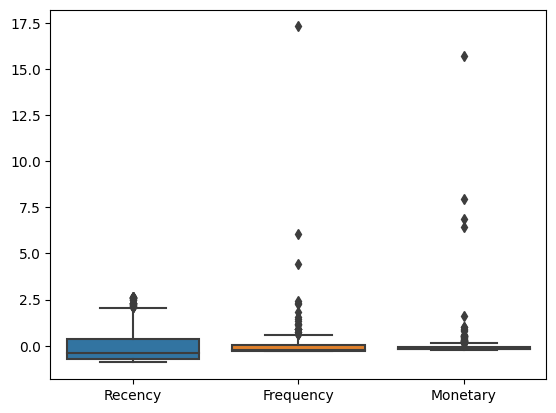

In [ ]:
sns.boxplot(data=df_rfm_standardized_non_uk)
plt.show()

In [ ]:
# sns.boxplot(data=df_scaled_non_uk)
# plt.show()

## Modeling

In [ ]:
# # Modeling
# possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# silhouette = []

# for k in possible_k:
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(df_rfm_non_uk)
#     silhouette.append(silhouette_score(X=df_rfm_non_uk, labels=kmeans.labels_))

In [ ]:
# # Modeling
# possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# silhouette = []

# for k in possible_k:
#     kmeans = KMeans(n_clusters=k, random_state=42).fit(df_scaled_non_uk)
#     silhouette.append(silhouette_score(X=df_scaled_non_uk, labels=kmeans.labels_))

In [ ]:
# Modeling
possible_k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette = []

for k in possible_k:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_rfm_standardized_non_uk)
    silhouette.append(silhouette_score(X=df_rfm_standardized_non_uk, labels=kmeans.labels_))

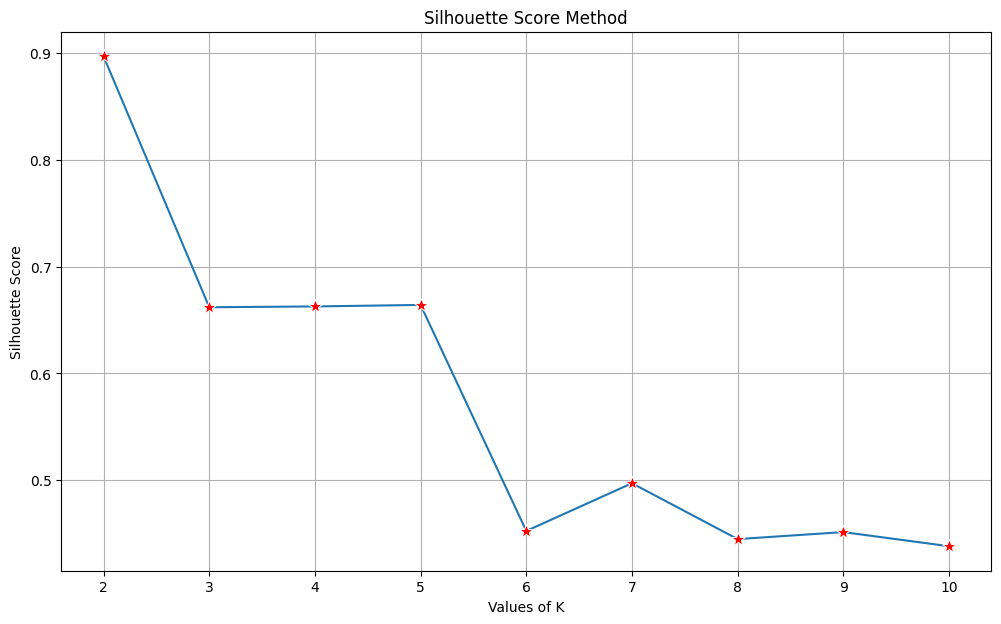

In [ ]:
# Plot the score
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=possible_k,
    y=silhouette,
    marker='*',
    markersize=10,
    markerfacecolor='red'
)
plt.xlabel('Values of K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.grid()
plt.show();

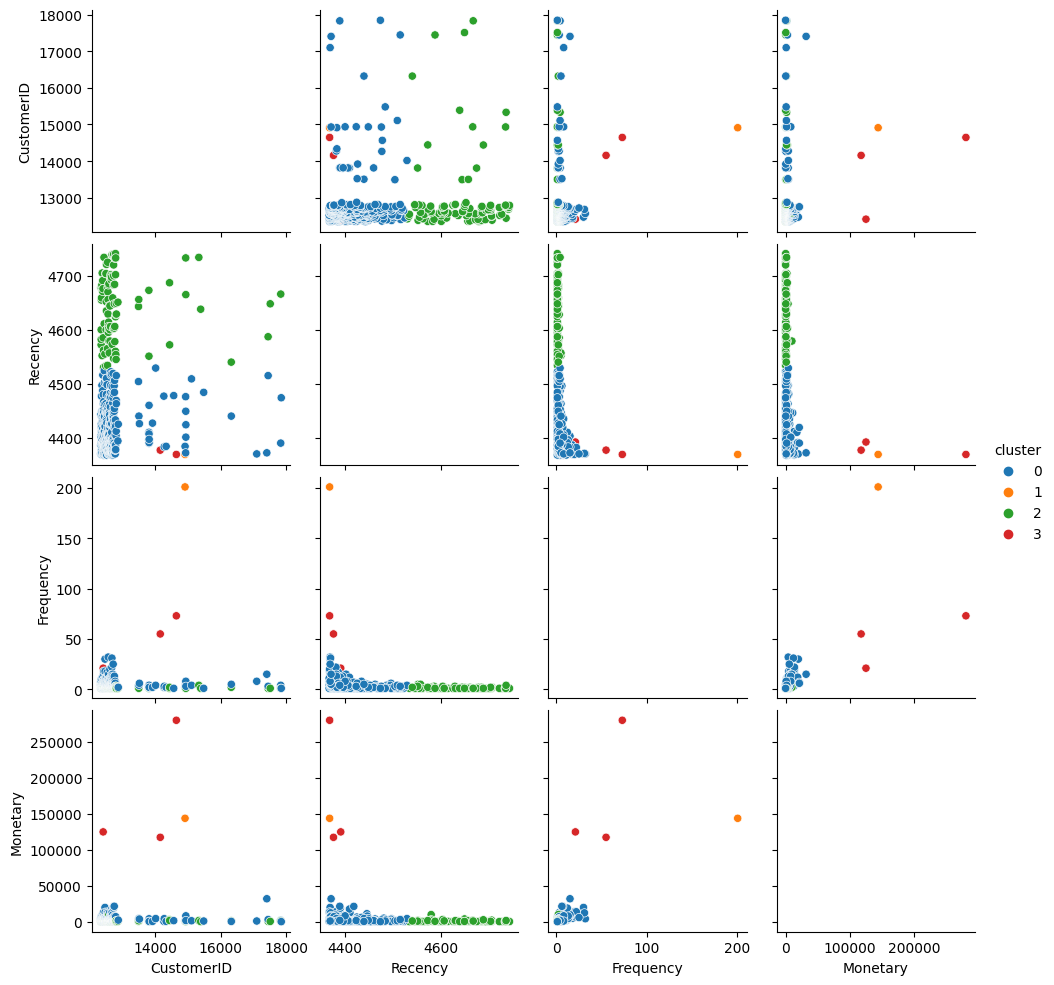

In [ ]:
kmeans = KMeans(n_clusters=4,random_state=42).fit(df_rfm_standardized_non_uk)

df_result_kmeans_nonuk = df_rfm_non_uk.copy()
df_result_kmeans_nonuk['cluster'] = kmeans.labels_

sns.pairplot(
    data=df_result_kmeans_nonuk,
    hue='cluster',
    diag_kind='None',
    palette='tab10'
)

plt.show();

In [ ]:
df_result_kmeans_nonuk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  418 non-null    float64
 1   Recency     418 non-null    int64  
 2   Frequency   418 non-null    int64  
 3   Monetary    418 non-null    float64
 4   cluster     418 non-null    int32  
dtypes: float64(2), int32(1), int64(2)
memory usage: 18.0 KB


In [ ]:
# Quantile function
def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

# Simple descriptive statistic
(
    df_result_kmeans_nonuk
    .drop("CustomerID", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0          1            2              3
Recency   mean     4413.959752    4369.00  4641.021978    4379.333333
          std        40.534261        NaN    60.683693      11.676187
          min      4368.000000    4369.00  4530.000000    4369.000000
          q25      4383.000000    4369.00  4591.000000    4373.000000
          median   4399.000000    4369.00  4648.000000    4377.000000
          q75      4439.500000    4369.00  4686.000000    4384.500000
          max      4529.000000    4369.00  4741.000000    4392.000000
Frequency mean        4.356037     201.00     1.417582      49.666667
          std         4.597480        NaN     0.817393      26.407070
          min         1.000000     201.00     1.000000      21.000000
          q25         2.000000     201.00     1.000000      38.000000
          median      3.000000     201.00     1.000000      55.000000
          q75         5.000000     201.00     2.000000      64.000000
          max        32.000000     201.00     5.000000      73.000000
Monetary  mean     2675.659845  143825.06   796.186593  174166.726667
          std      3787.829719        NaN  1201.683175   91909.969413
          min        51.560000  143825.06    63.000000  117379.630000
          q25       611.405000  143825.06   225.750000  121147.080000
          median   1298.040000  143825.06   433.740000  124914.530000
          q75      3341.300000  143825.06   851.870000  202560.275000
          max     31906.820000  143825.06  9864.260000  280206.020000

## Korelasi

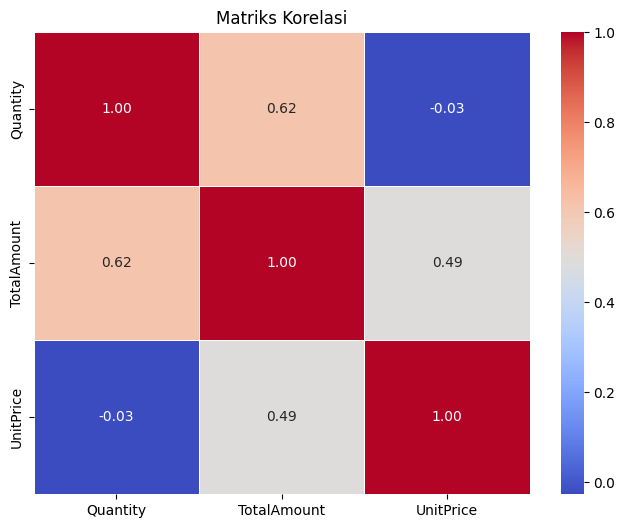

In [ ]:
# Pilih kolom yang ingin dihitung korelasinya
selected_columns = ['Quantity', 'TotalAmount', 'UnitPrice']

# Buat matriks korelasi
correlation_matrix = df_non_uk[selected_columns].corr()

# Visualisasi heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriks Korelasi')
plt.show()

Terdapat Korelasi Positif yang lumayan kuat antara Quantity dengan TotalAmount. Yang berarti ketika nilai satu variabel meningkat, nilai variabel lainnya juga cenderung meningkat

## Bandingkan distribusi segmentasi pelanggan

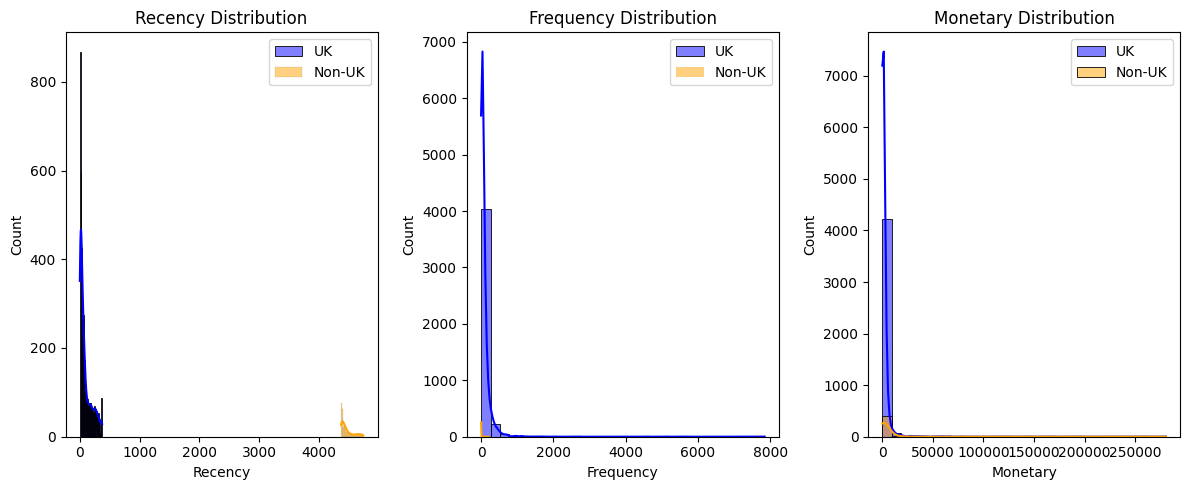

In [ ]:
# Segmentasi Pelanggan di UK
uk_customer_segments = df_new.groupby('CustomerID').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary Spent': 'mean'
}).reset_index()

# Segmentasi Pelanggan di Non-UK
non_uk_customer_segments = df_rfm_non_uk.groupby('CustomerID').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Plot histogram untuk Recency
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(uk_customer_segments['Recency'], bins=30, kde=True, color='blue', label='UK')
sns.histplot(non_uk_customer_segments['Recency'], bins=30, kde=True, color='orange', label='Non-UK')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.legend()

# Plot histogram untuk Frequency
plt.subplot(1, 3, 2)
sns.histplot(uk_customer_segments['Frequency'], bins=30, kde=True, color='blue', label='UK')
sns.histplot(non_uk_customer_segments['Frequency'], bins=30, kde=True, color='orange', label='Non-UK')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.legend()

# Plot histogram untuk Monetary
plt.subplot(1, 3, 3)
sns.histplot(uk_customer_segments['Monetary Spent'], bins=30, kde=True, color='blue', label='UK')
sns.histplot(non_uk_customer_segments['Monetary'], bins=30, kde=True, color='orange', label='Non-UK')
plt.title('Monetary Distribution')
plt.xlabel('Monetary')
plt.legend()

plt.tight_layout()
plt.show()

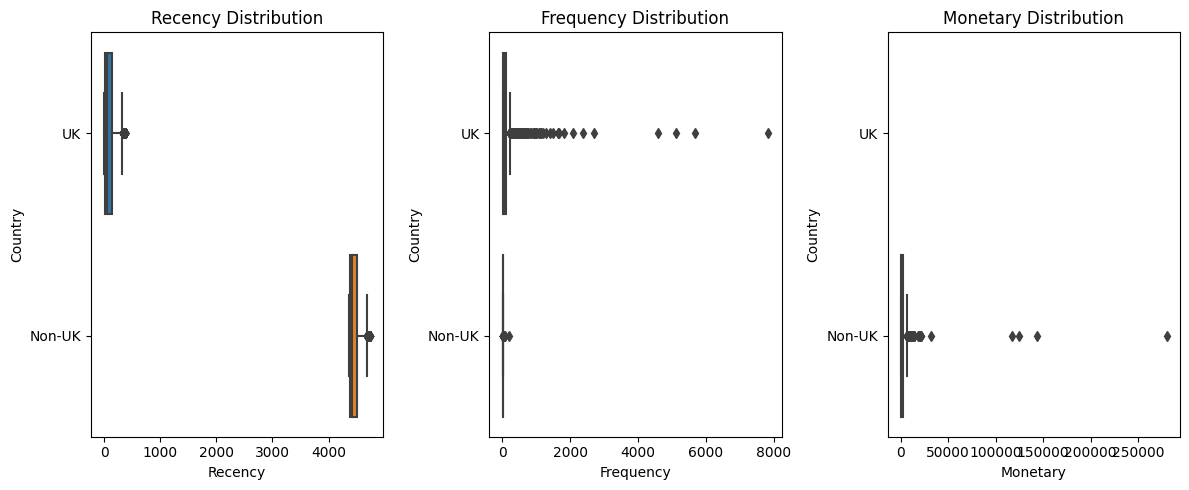

In [ ]:
# Plot boxplot untuk Recency
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='Recency', y='Country', data=pd.concat([uk_customer_segments.assign(Country='UK'), non_uk_customer_segments.assign(Country='Non-UK')]))
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Country')

# Plot boxplot untuk Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Frequency', y='Country', data=pd.concat([uk_customer_segments.assign(Country='UK'), non_uk_customer_segments.assign(Country='Non-UK')]))
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Country')

# Plot boxplot untuk Monetary
plt.subplot(1, 3, 3)
sns.boxplot(x='Monetary', y='Country', data=pd.concat([uk_customer_segments.assign(Country='UK'), non_uk_customer_segments.assign(Country='Non-UK')]))
plt.title('Monetary Distribution')
plt.xlabel('Monetary')
plt.ylabel('Country')

plt.tight_layout()
plt.show()

In [ ]:
(
    df_result_kmeans_nonuk
    .drop("CustomerID", axis = 1)
    .groupby('cluster')
    .aggregate(['mean', 'std', 'min', q25, 'median', q75, 'max'])
    .transpose()
)

cluster                      0          1            2              3
Recency   mean     4413.959752    4369.00  4641.021978    4379.333333
          std        40.534261        NaN    60.683693      11.676187
          min      4368.000000    4369.00  4530.000000    4369.000000
          q25      4383.000000    4369.00  4591.000000    4373.000000
          median   4399.000000    4369.00  4648.000000    4377.000000
          q75      4439.500000    4369.00  4686.000000    4384.500000
          max      4529.000000    4369.00  4741.000000    4392.000000
Frequency mean        4.356037     201.00     1.417582      49.666667
          std         4.597480        NaN     0.817393      26.407070
          min         1.000000     201.00     1.000000      21.000000
          q25         2.000000     201.00     1.000000      38.000000
          median      3.000000     201.00     1.000000      55.000000
          q75         5.000000     201.00     2.000000      64.000000
          max        32.000000     201.00     5.000000      73.000000
Monetary  mean     2675.659845  143825.06   796.186593  174166.726667
          std      3787.829719        NaN  1201.683175   91909.969413
          min        51.560000  143825.06    63.000000  117379.630000
          q25       611.405000  143825.06   225.750000  121147.080000
          median   1298.040000  143825.06   433.740000  124914.530000
          q75      3341.300000  143825.06   851.870000  202560.275000
          max     31906.820000  143825.06  9864.260000  280206.020000

# Kesimpulan

Berdasarkan hasil output dari analisis karakteristik utama dari masing-masing cluster non UK, berikut adalah beberapa kesimpulan yang dapat diambil:

**Cluster 0:**
- Rata-rata Recency tinggi (4413.43), Frequency rendah (4.36), Monetary Spent tinggi (2675.66).
- Tren pembelian cenderung kurang aktif.
- Promo yang cocok:
  - Program Diskon Lanjutan: Memberikan diskon atau penawaran spesial kepada pelanggan dalam upaya meningkatkan frekuensi pembelian.
  - Program Poin Reward: Memberikan poin reward untuk setiap pembelian yang dapat ditukarkan dengan diskon atau hadiah khusus.

**Cluster 1:**
- Semua nilai pada cluster ini memiliki nilai yang sama, hal ini mungkin disebabkan oleh suatu kesalahan atau masalah dalam data.
- Perlu dilakukan pengecekan lebih lanjut terhadap data pada cluster ini.

**Cluster 2:**
- Rata-rata Recency menengah (4640.48), Frequency rendah (1.42), Monetary Spent rendah (796.19).
- Tren pembelian cenderung kurang aktif.
- Promo yang cocok:
  - Diskon Khusus: Menawarkan diskon eksklusif atau penawaran istimewa untuk meningkatkan frekuensi pembelian.
  - Program Diskon Bertingkat: Memberikan diskon tambahan untuk setiap pembelian tambahan.

**Cluster 3:**
- Rata-rata Recency tinggi (4379.00), Frequency sedang (49.67), Monetary Spent tinggi (174166.73).
- Tren pembelian cenderung kurang aktif, tetapi nilai transaksi tinggi.
- Promo yang cocok:
  - Program VIP: Program eksklusif VIP dengan reward khusus, diskon besar, atau akses ke produk atau acara eksklusif.
  - Program Penghargaan Transaksi Tinggi: Memberikan reward atau diskon khusus untuk setiap transaksi dengan nilai tinggi.

**Catatan:**
- Cluster 1 memiliki nilai yang sama untuk semua fitur, yang mungkin merupakan anomali atau masalah dalam data. Perlu diperiksa lebih lanjut untuk memahami penyebabnya.

Kesimpulannya, karakteristik masing-masing cluster dapat memberikan arah untuk mengembangkan strategi pemasaran dan promosi yang lebih sesuai dengan kebutuhan pelanggan di setiap cluster.

